In [1]:
import pandas as pd
import numpy as np
from matplotlib.ticker import LogFormatter
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
import json
import plategig

PROJECT_PATH = Path('/project/greencenter/Toprak_lab/shared/plategig/projects')
PROJECT_ID = '241011_Adam'

#### Step 1: Read Plate Information

In [2]:
# Read the Excel file into a DataFrame
df_plate_info = pd.read_excel(PROJECT_PATH / PROJECT_ID / 'data' / 'PlateInfo.xlsx', engine='openpyxl')
df_plate_info

Experiment  Plate Well      Strain  Culture  Replicate    Antibiotic  \
0               1      1   A1           P      1.0        1.0  Levofloxacin   
1               1      1   A2           P      1.0        1.0  Levofloxacin   
2               1      1   A3           P      1.0        1.0  Levofloxacin   
3               1      1   A4           P      1.0        1.0  Levofloxacin   
4               1      1   A5           P      1.0        1.0  Levofloxacin   
...           ...    ...  ...         ...      ...        ...           ...   
14587           3      4   H8  Media Only      NaN        NaN           NaN   
14588           3      4   H9  Media Only      NaN        NaN           NaN   
14589           3      4  H10  Media Only      NaN        NaN           NaN   
14590           3      4  H11  Media Only      NaN        NaN           NaN   
14591           3      4  H12  Media Only      NaN        NaN           NaN   

       Dose  
0       8.0  
1       4.0  
2       2.0  
3       1.0  
4       0.5  
...     ...  
14587   NaN  
14588   NaN  
14589   NaN  
14590   NaN  
14591   NaN  

[14592 rows x 8 columns]

In [3]:
def calculate_plate_id(row):
    if row['Experiment'] == 1:
        return row['Plate']
    elif row['Experiment'] == 2:
        return row['Plate'] + 99
    elif row['Experiment'] == 3:
        return row['Plate'] + 148
    else:
        return None  # Handle other experiments if needed

# Step 2: Apply the function to each row in the DataFrame and create the new 'Plate_ID' column
df_plate_info['Plate_ID'] = df_plate_info.apply(calculate_plate_id, axis=1)

# Step 3: Display the updated DataFrame
print(df_plate_info.head())

   Experiment  Plate Well Strain  Culture  Replicate    Antibiotic  Dose  \
0           1      1   A1      P      1.0        1.0  Levofloxacin   8.0   
1           1      1   A2      P      1.0        1.0  Levofloxacin   4.0   
2           1      1   A3      P      1.0        1.0  Levofloxacin   2.0   
3           1      1   A4      P      1.0        1.0  Levofloxacin   1.0   
4           1      1   A5      P      1.0        1.0  Levofloxacin   0.5   

   Plate_ID  
0         1  
1         1  
2         1  
3         1  
4         1  


Collect unique plate IDs

unique_plate_ids, plate_numbers = growthlib.get_unique_plate_ids(df_plate_info)
unique_plate_ids

#### Step 2: Read the raw OD data

In [4]:
df_OD_raw = pd.read_excel(PROJECT_PATH / PROJECT_ID / 'data' /'ODFinal.xlsx')
# drop last nan column, fix to input mistake
df_OD_raw = df_OD_raw.iloc[:,:-1]
df_OD_raw.tail()

Unnamed: 0      1      2      3      4      5      6      7      8  \
1513          D  0.044  0.046  0.045  0.045  0.045  0.044  0.044  0.044   
1514          E  0.467  0.486  0.478  0.456  0.461  0.044  0.045  0.045   
1515          F  0.453  0.453  0.444  0.478  0.489  0.044  0.044  0.045   
1516          G  0.463  0.454  0.457  0.542  0.518  0.044  0.044  0.044   
1517          H  0.046  0.045  0.046  0.046  0.046  0.045  0.044  0.046   

          9     10     11     12   0.046414  
1513  0.044  0.044  0.044  0.045  od600:600  
1514  0.045  0.044  0.046  0.046  od600:600  
1515  0.045  0.044  0.045  0.046  od600:600  
1516  0.045  0.046  0.046  0.046  od600:600  
1517  0.046  0.045  0.046  0.046  od600:600

In [5]:
df = plategig.static.convert_OD_plate_to_long(df_OD_raw, df_plate_info)
df

Plate_ID Well     OD  Row  Column
0             1   A1  0.053    1       1
1             1   A2  0.050    1       2
2             1   A3  0.051    1       3
3             1   A4  0.053    1       4
4             1   A5  0.057    1       5
...         ...  ...    ...  ...     ...
14587       152   H8  0.046    8       8
14588       152   H9  0.046    8       9
14589       152  H10  0.045    8      10
14590       152  H11  0.046    8      11
14591       152  H12  0.046    8      12

[14592 rows x 5 columns]

Calculate median background of all plates to impute plates with missing media-only wells.

In [6]:
df_plate_info[df_plate_info['Strain']=='Media Only']

Experiment  Plate Well      Strain  Culture  Replicate Antibiotic  \
8208            1     33   E1  Media Only      NaN        NaN        NaN   
8209            1     33   E2  Media Only      NaN        NaN        NaN   
8210            1     33   E3  Media Only      NaN        NaN        NaN   
8211            1     33   E4  Media Only      NaN        NaN        NaN   
8212            1     33   E5  Media Only      NaN        NaN        NaN   
...           ...    ...  ...         ...      ...        ...        ...   
14587           3      4   H8  Media Only      NaN        NaN        NaN   
14588           3      4   H9  Media Only      NaN        NaN        NaN   
14589           3      4  H10  Media Only      NaN        NaN        NaN   
14590           3      4  H11  Media Only      NaN        NaN        NaN   
14591           3      4  H12  Media Only      NaN        NaN        NaN   

       Dose  Plate_ID  
8208    NaN        33  
8209    NaN        33  
8210    NaN        33  
8211    NaN        33  
8212    NaN        33  
...     ...       ...  
14587   NaN       152  
14588   NaN       152  
14589   NaN       152  
14590   NaN       152  
14591   NaN       152  

[2808 rows x 9 columns]

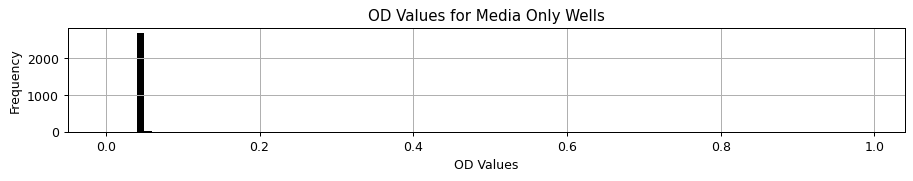

0.045


In [7]:

median_background_all_plates = plategig.static.calc_median_background_all_plates(
    df, df_plate_info, plot=True)
#I had to make these changes because there was a problem with the plate map info, confirm with Adam.
print(median_background_all_plates)

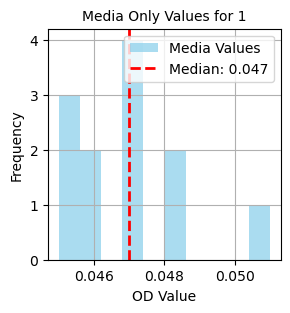

np.float64(0.047)

In [8]:
plategig.static.plot_single_plate_media_only_wells(df, df_plate_info, plate_id=1, column_name='OD')

Apply background correction for all plates

In [9]:
df_bc = df.copy()
df_bc['OD_final'] = df_bc['OD'] - median_background_all_plates

#### Evaluate growth metrics

In [10]:
df_bc

Plate_ID Well     OD  Row  Column  OD_final
0             1   A1  0.053    1       1     0.008
1             1   A2  0.050    1       2     0.005
2             1   A3  0.051    1       3     0.006
3             1   A4  0.053    1       4     0.008
4             1   A5  0.057    1       5     0.012
...         ...  ...    ...  ...     ...       ...
14587       152   H8  0.046    8       8     0.001
14588       152   H9  0.046    8       9     0.001
14589       152  H10  0.045    8      10     0.000
14590       152  H11  0.046    8      11     0.001
14591       152  H12  0.046    8      12     0.001

[14592 rows x 6 columns]

In [11]:
# Prep the analysis dataframe
df_analysis = pd.merge(df_plate_info, df_bc, on=['Plate_ID', 'Well'])
df_analysis = df_analysis[['Experiment','Strain', 'Culture', 'Replicate', 'Antibiotic',
                           'Dose', 'Plate_ID', 'Well', 'Row', 'Column',
                           'OD', 'OD_final']]
# Remove control wells
df_analysis = df_analysis[~df_analysis['Strain'].isin(['Media Only','Cells Only'])]
# Keep group names
df_analysis['Group'] = df_analysis.Strain
# Define each culture of as a separate strain
df_analysis['Strain'] = df_analysis.Strain + df_analysis.Culture.astype(int).astype(str)
df_analysis


Experiment     Strain  Culture  Replicate    Antibiotic      Dose  \
0               1         P1      1.0        1.0  Levofloxacin  8.000000   
1               1         P1      1.0        1.0  Levofloxacin  4.000000   
2               1         P1      1.0        1.0  Levofloxacin  2.000000   
3               1         P1      1.0        1.0  Levofloxacin  1.000000   
4               1         P1      1.0        1.0  Levofloxacin  0.500000   
...           ...        ...      ...        ...           ...       ...   
14542           3  ATEC-C-r1      1.0        3.0      Cefepime  0.062500   
14543           3  ATEC-C-r1      1.0        3.0      Cefepime  0.031250   
14544           3  ATEC-C-r1      1.0        3.0      Cefepime  0.015625   
14545           3  ATEC-C-r1      1.0        3.0      Cefepime  0.007812   
14546           3  ATEC-C-r1      1.0        3.0      Cefepime  0.003906   

       Plate_ID Well  Row  Column     OD  OD_final     Group  
0             1   A1    1       1  0.053     0.008         P  
1             1   A2    1       2  0.050     0.005         P  
2             1   A3    1       3  0.051     0.006         P  
3             1   A4    1       4  0.053     0.008         P  
4             1   A5    1       5  0.057     0.012         P  
...         ...  ...  ...     ...    ...       ...       ...  
14542       152   G1    7       1  0.463     0.418  ATEC-C-r  
14543       152   G2    7       2  0.454     0.409  ATEC-C-r  
14544       152   G3    7       3  0.457     0.412  ATEC-C-r  
14545       152   G4    7       4  0.542     0.497  ATEC-C-r  
14546       152   G5    7       5  0.518     0.473  ATEC-C-r  

[11784 rows x 13 columns]

In [12]:
# TOdo:
# Remove some failed experiments:
# From experiment 1
#   ‘strain’ == ‘PAC’         (not used)
#   ‘strain’ == PCr             (range to small)
#   cultures == PLAC7 & PLAC10        (bad curve)
# From Experiment 2
#    ATEC 1,2,4     (plating error)
#    ATEC-C 3       (plating error)
#    ATEC-C-r        (plating error)
### Groups to remove
    # PAC
    # P
# Define the combinations of 'Experiment' and 'Group' to remove
df_analysis['Experiment'] = df_analysis['Experiment'].astype(str).str.strip()

groups_to_remove = [('1', 'PAC'), ('1', 'PCr')]

# Remove rows where the 'Experiment' and 'Group' match the combinations in groups_to_remove
df_analysis = df_analysis[~df_analysis[['Experiment', 'Group']].apply(tuple, axis=1).isin(groups_to_remove)]

# Define the combinations of 'Experiment' and 'Strain' to remove
strains_to_remove = [('1', 'PLAC7'), ('1', 'PLAC10')]

# Remove rows where the 'Experiment' and 'Strain' match the combinations in strains_to_remove
df_analysis = df_analysis[~df_analysis[['Experiment', 'Strain']].apply(tuple, axis=1).isin(strains_to_remove)]

# Define the combinations of 'Experiment' and 'Strain' to remove
atec_to_remove = [('2', 'ATEC-C-R', 'Cefepime'),('2', 'ATEC1', 'Cefepime'), ('2', 'ATEC2', 'Cefepime'), ('2', 'ATEC4', 'Cefepime'), ('2', 'ATEC-C3', 'Cefepime')]

# Remove rows where the 'Experiment' and 'Strain' match the combinations in strains_to_remove
df_analysis = df_analysis[~df_analysis[['Experiment', 'Strain', 'Antibiotic']].apply(tuple, axis=1).isin(atec_to_remove)]

df_analysis




Experiment     Strain  Culture  Replicate    Antibiotic      Dose  \
0              1         P1      1.0        1.0  Levofloxacin  8.000000   
1              1         P1      1.0        1.0  Levofloxacin  4.000000   
2              1         P1      1.0        1.0  Levofloxacin  2.000000   
3              1         P1      1.0        1.0  Levofloxacin  1.000000   
4              1         P1      1.0        1.0  Levofloxacin  0.500000   
...          ...        ...      ...        ...           ...       ...   
14542          3  ATEC-C-r1      1.0        3.0      Cefepime  0.062500   
14543          3  ATEC-C-r1      1.0        3.0      Cefepime  0.031250   
14544          3  ATEC-C-r1      1.0        3.0      Cefepime  0.015625   
14545          3  ATEC-C-r1      1.0        3.0      Cefepime  0.007812   
14546          3  ATEC-C-r1      1.0        3.0      Cefepime  0.003906   

       Plate_ID Well  Row  Column     OD  OD_final     Group  
0             1   A1    1       1  0.053     0.008         P  
1             1   A2    1       2  0.050     0.005         P  
2             1   A3    1       3  0.051     0.006         P  
3             1   A4    1       4  0.053     0.008         P  
4             1   A5    1       5  0.057     0.012         P  
...         ...  ...  ...     ...    ...       ...       ...  
14542       152   G1    7       1  0.463     0.418  ATEC-C-r  
14543       152   G2    7       2  0.454     0.409  ATEC-C-r  
14544       152   G3    7       3  0.457     0.412  ATEC-C-r  
14545       152   G4    7       4  0.542     0.497  ATEC-C-r  
14546       152   G5    7       5  0.518     0.473  ATEC-C-r  

[9636 rows x 13 columns]

In [13]:
unique_groups = df_analysis['Group'].unique().tolist()
print(unique_groups)

['P', 'PA', 'PC', 'PL', 'PLA', 'PLAC', 'PCr', 'ATEC', 'ATEC-C', 'ATEC-C-r']


In [14]:
# Select subgroups
df_analysis = df_analysis.query("Group.isin(['ATEC','ATEC-C','ATEC-C-r'])")
df_analysis

Experiment     Strain  Culture  Replicate    Antibiotic      Dose  \
10008          2      ATEC1      1.0        1.0  Levofloxacin  8.000000   
10009          2      ATEC1      1.0        1.0  Levofloxacin  4.000000   
10010          2      ATEC1      1.0        1.0  Levofloxacin  2.000000   
10011          2      ATEC1      1.0        1.0  Levofloxacin  1.000000   
10012          2      ATEC1      1.0        1.0  Levofloxacin  0.500000   
...          ...        ...      ...        ...           ...       ...   
14542          3  ATEC-C-r1      1.0        3.0      Cefepime  0.062500   
14543          3  ATEC-C-r1      1.0        3.0      Cefepime  0.031250   
14544          3  ATEC-C-r1      1.0        3.0      Cefepime  0.015625   
14545          3  ATEC-C-r1      1.0        3.0      Cefepime  0.007812   
14546          3  ATEC-C-r1      1.0        3.0      Cefepime  0.003906   

       Plate_ID Well  Row  Column     OD  OD_final     Group  
10008       107   B1    2       1  0.047     0.002      ATEC  
10009       107   B2    2       2  0.047     0.002      ATEC  
10010       107   B3    2       3  0.053     0.008      ATEC  
10011       107   B4    2       4  0.053     0.008      ATEC  
10012       107   B5    2       5  0.054     0.009      ATEC  
...         ...  ...  ...     ...    ...       ...       ...  
14542       152   G1    7       1  0.463     0.418  ATEC-C-r  
14543       152   G2    7       2  0.454     0.409  ATEC-C-r  
14544       152   G3    7       3  0.457     0.412  ATEC-C-r  
14545       152   G4    7       4  0.542     0.497  ATEC-C-r  
14546       152   G5    7       5  0.518     0.473  ATEC-C-r  

[1650 rows x 13 columns]

In [15]:
### Double check
unique_columns = df_analysis.columns.tolist()

# Print the list of unique columns
print(unique_columns)

#
unique_values = df_analysis['Strain'].unique()

# Print the unique values
print(unique_values)

['Experiment', 'Strain', 'Culture', 'Replicate', 'Antibiotic', 'Dose', 'Plate_ID', 'Well', 'Row', 'Column', 'OD', 'OD_final', 'Group']
['ATEC1' 'ATEC2' 'ATEC3' 'ATEC4' 'ATEC5' 'ATEC6' 'ATEC-C1' 'ATEC-C2'
 'ATEC-C3' 'ATEC-C4' 'ATEC-C5' 'ATEC-C6' 'ATEC-C-r1']


In [16]:
antibiotics = df_analysis['Antibiotic'].unique()
antibiotics 

array(['Levofloxacin', 'Amikacin', 'Cefepime'], dtype=object)

In [17]:
df_analysis.query("Antibiotic == 'Levofloxacin' & Strain == 'P1'")

Empty DataFrame
Columns: [Experiment, Strain, Culture, Replicate, Antibiotic, Dose, Plate_ID, Well, Row, Column, OD, OD_final, Group]
Index: []

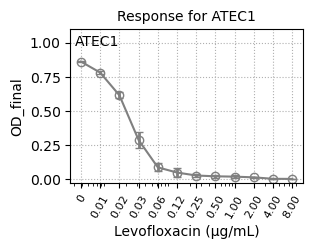

In [18]:

# Adjust the figure size as needed
fig, ax = plt.subplots(figsize=(3, 2))
plategig.static.plot_dose_response_curve_errorbar(df_analysis, 'ATEC1', 'Levofloxacin', strain_colors={'P1':'black'}, ax=ax)

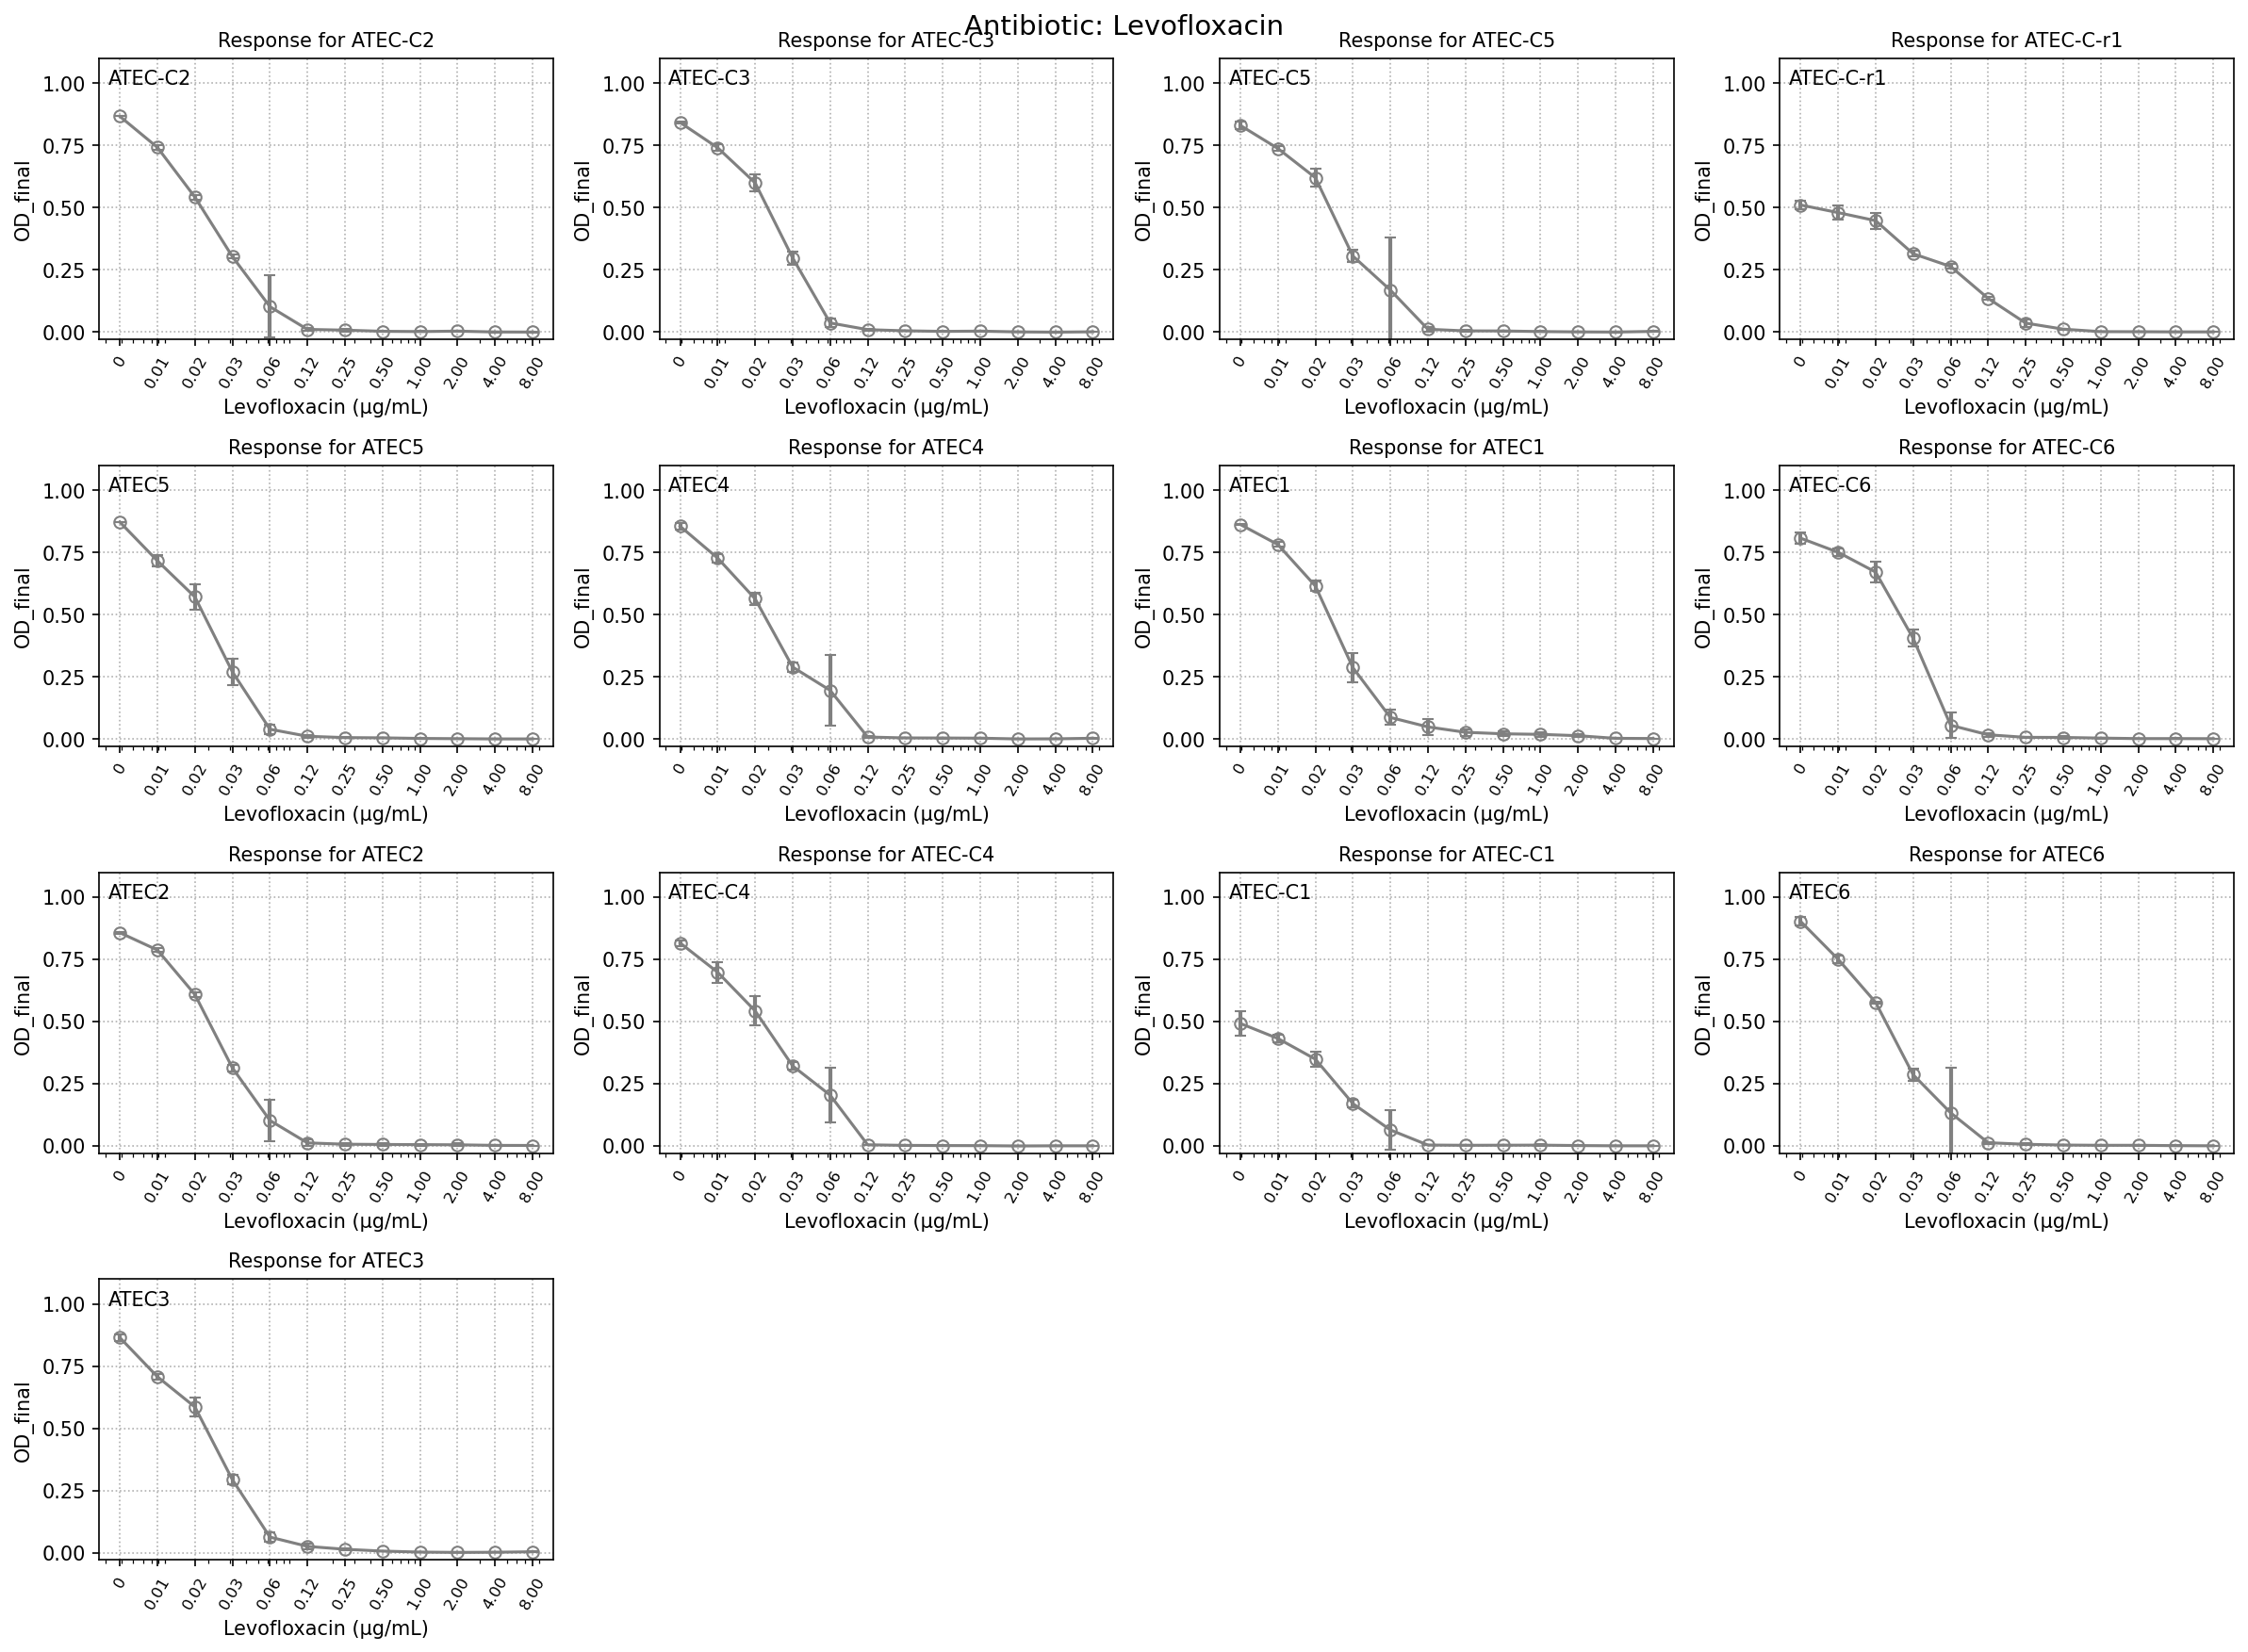

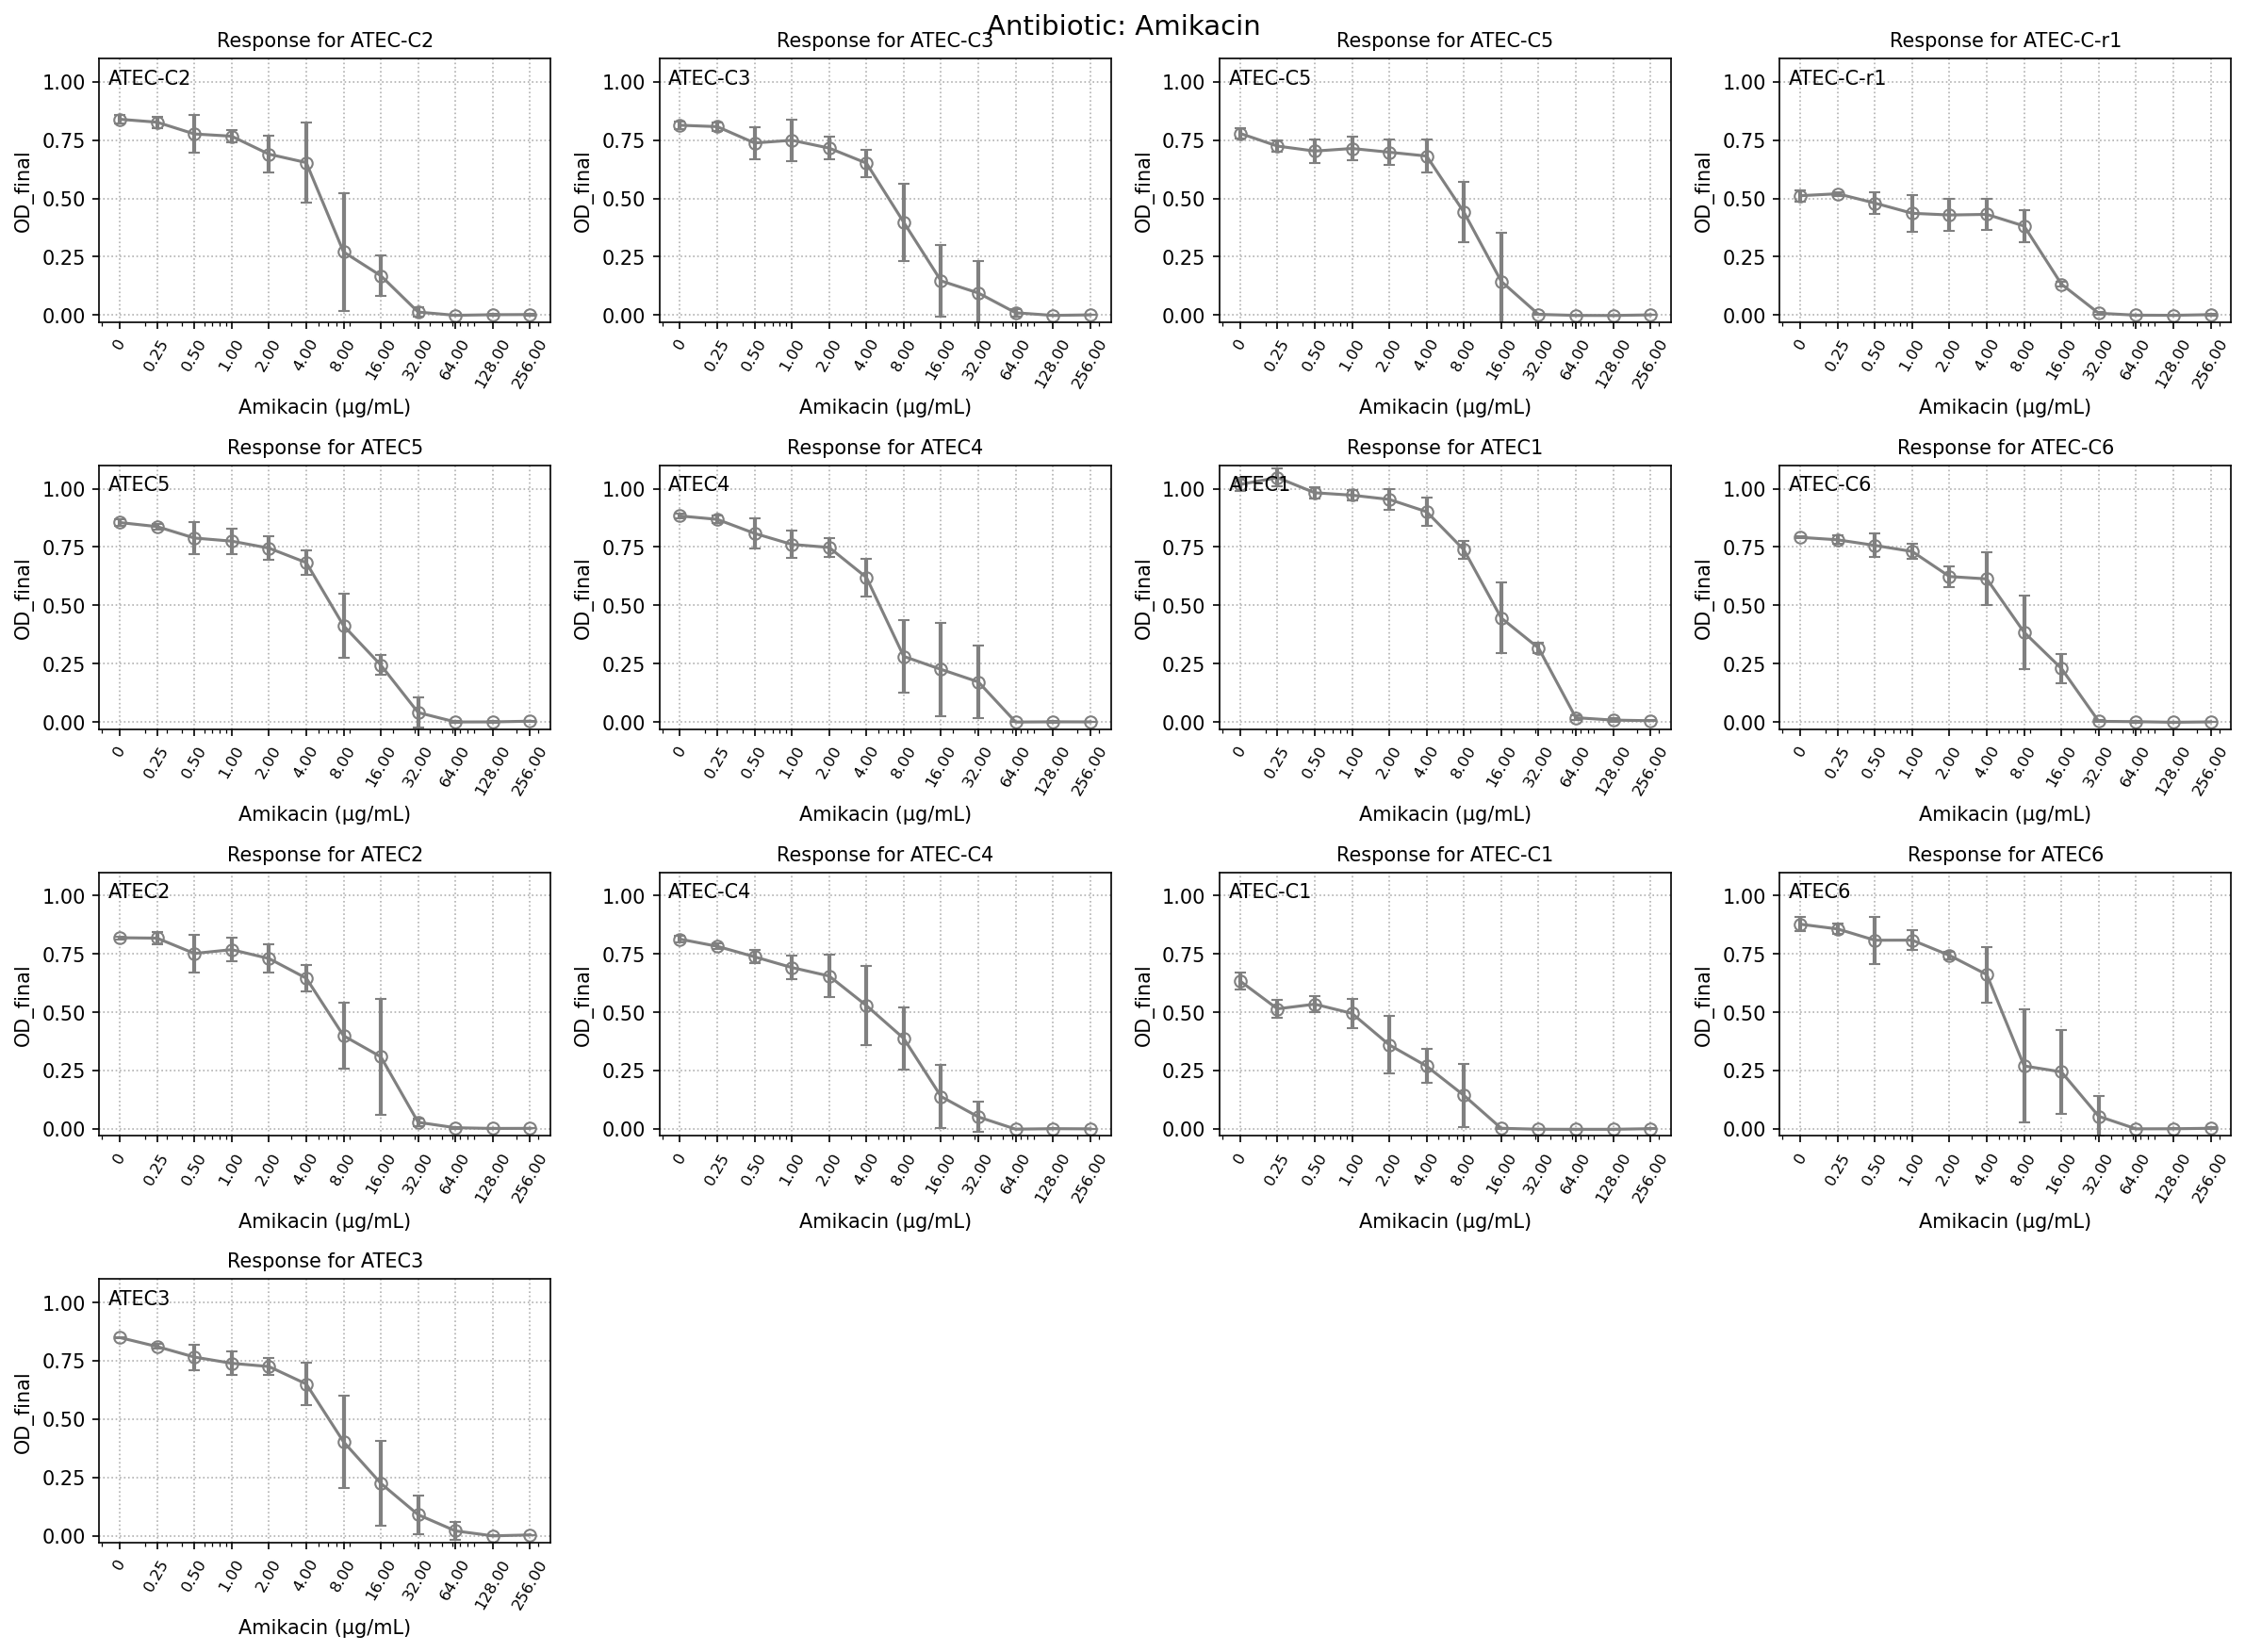

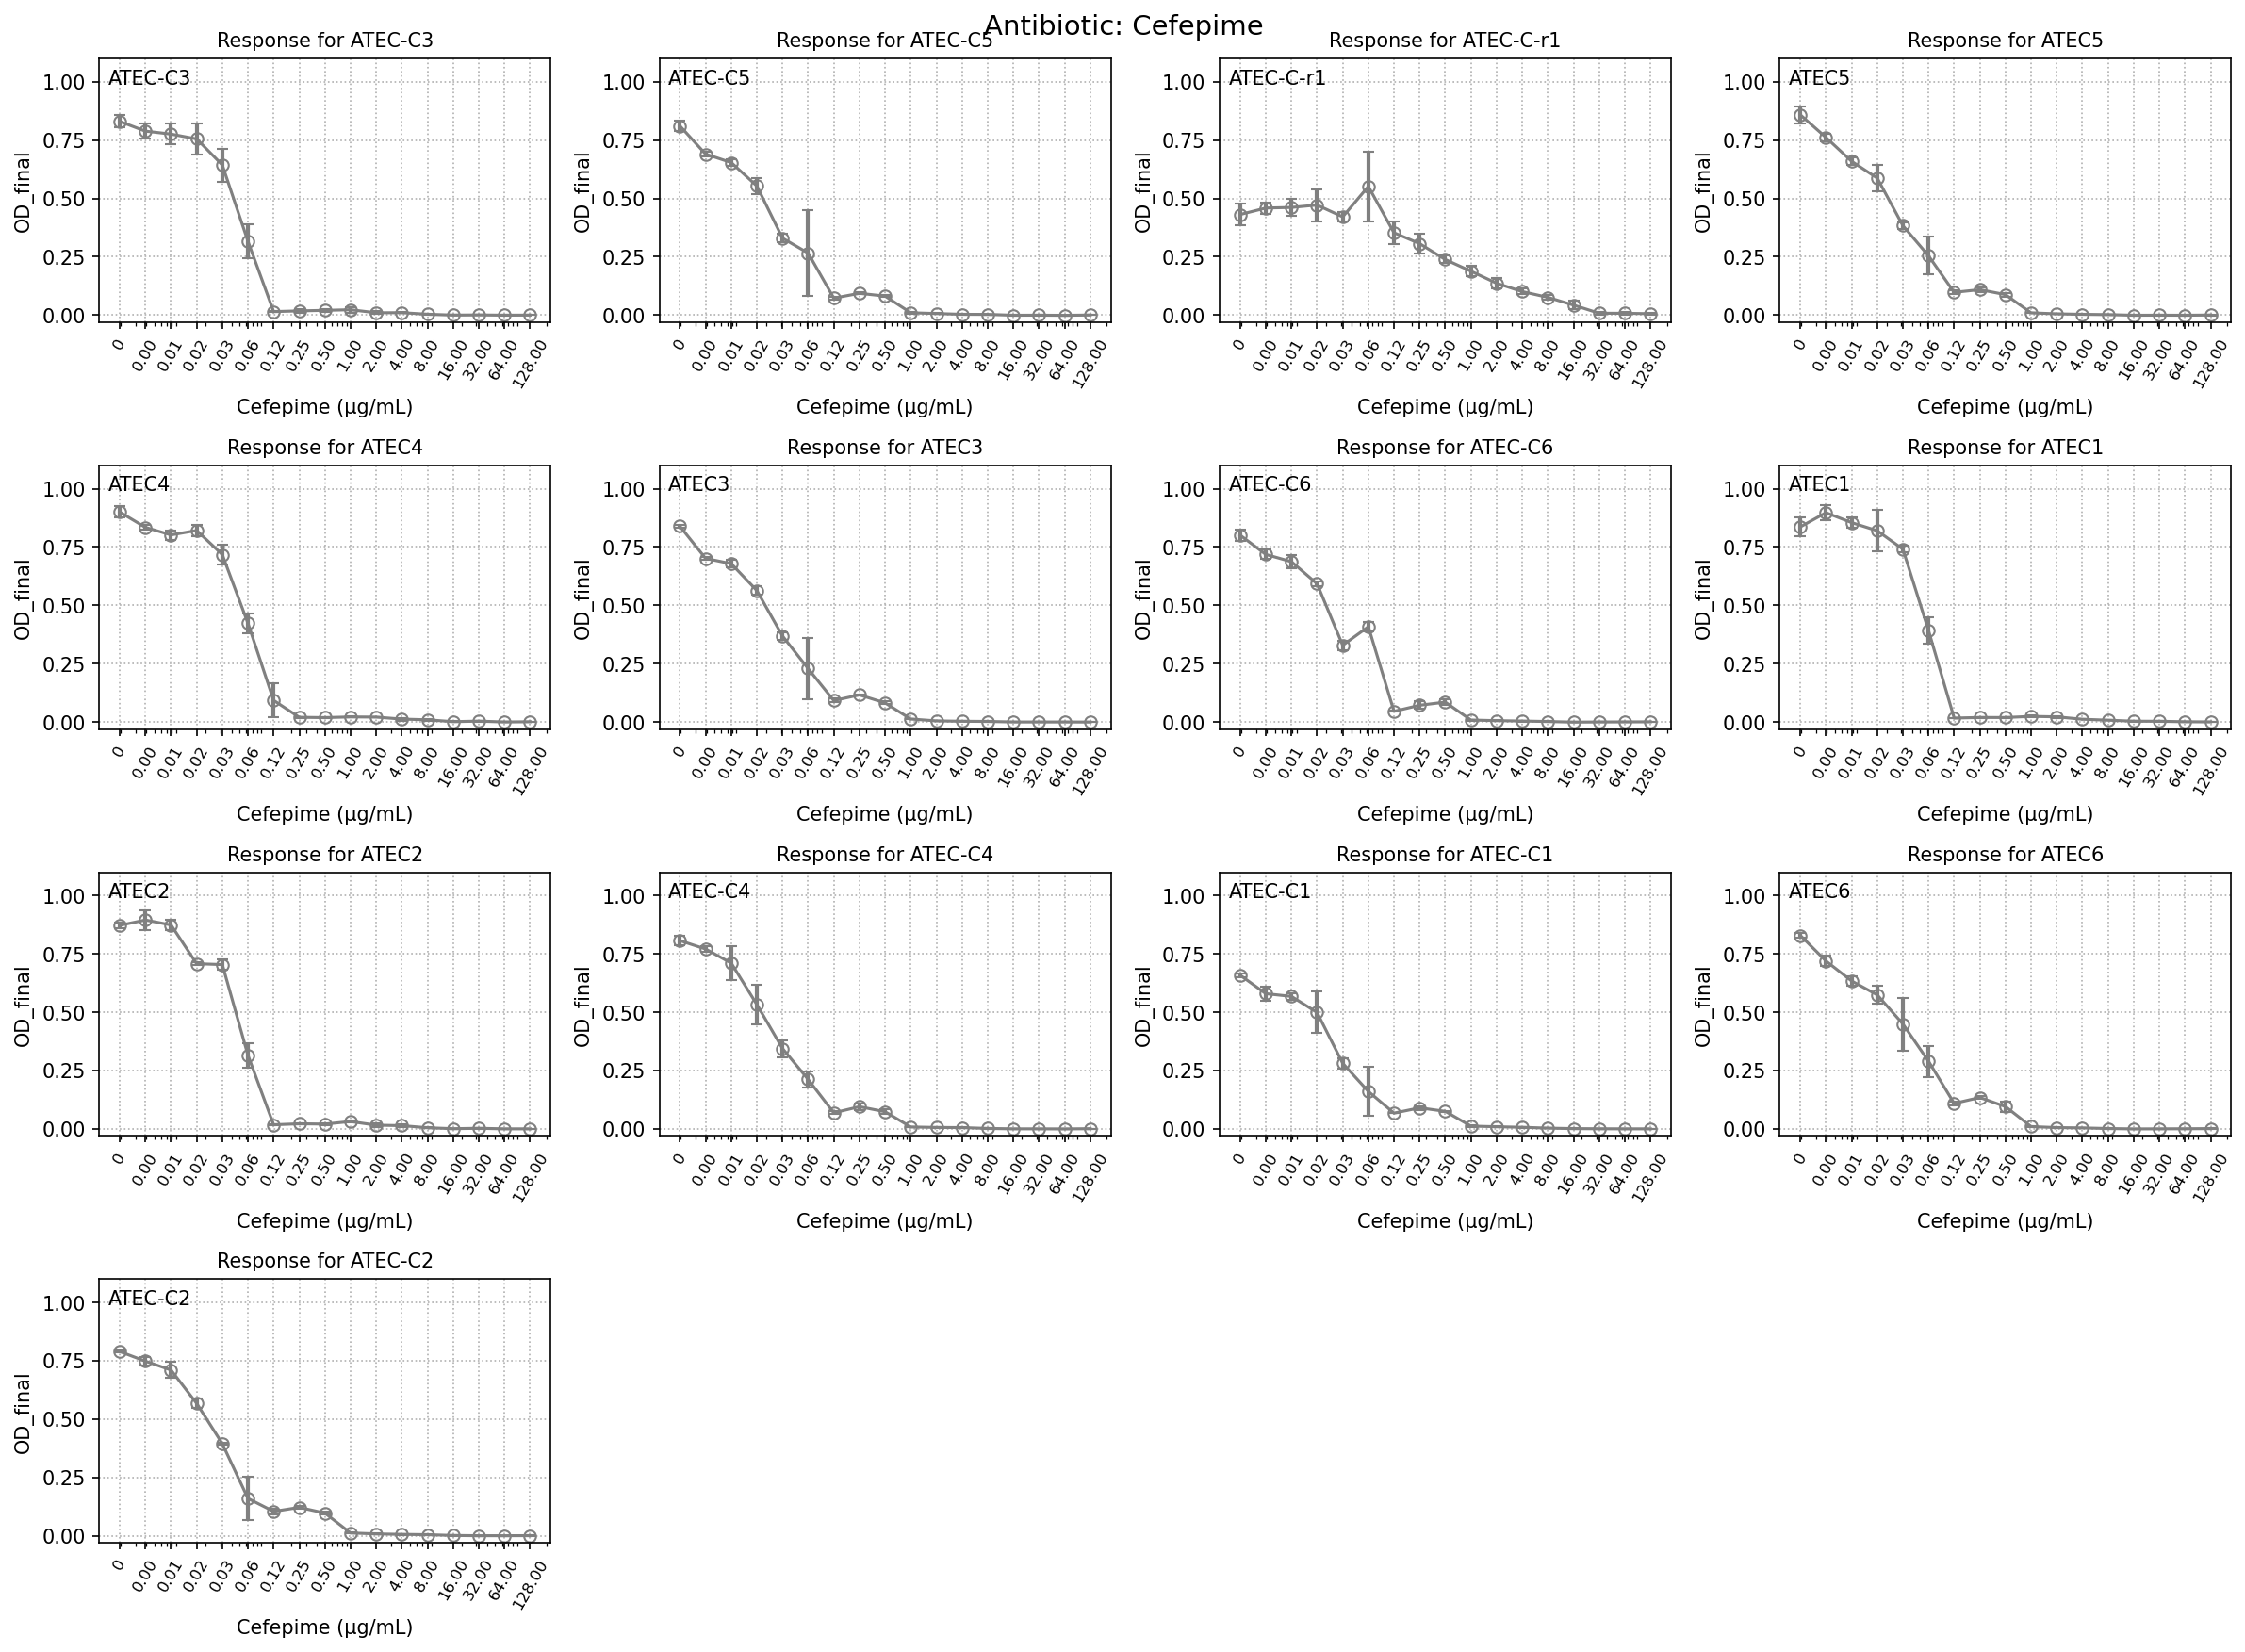

In [19]:
# Plot all dose-response curves in the df_analysis tables (might take too long)
for drug in antibiotics:
    if not pd.isna(drug):
        plategig.static.plot_od_final_for_selected_antibiotic(
            df_analysis,
            plategig.static.plot_dose_response_curve_errorbar,
            drug,
            strain_colors={})

In [19]:
valid_combinations = plategig.static.prep_valid_combinations(
    df_analysis,
    multiplex=['Strain', 'Antibiotic'],
    ic50_threshold=0.5,
    mic_threshold=0.05)
valid_combinations

Strain    Antibiotic
0       ATEC1  Levofloxacin
1       ATEC2  Levofloxacin
2       ATEC3  Levofloxacin
3       ATEC4  Levofloxacin
4       ATEC5  Levofloxacin
5       ATEC6  Levofloxacin
6     ATEC-C1  Levofloxacin
7     ATEC-C2  Levofloxacin
8     ATEC-C3  Levofloxacin
9     ATEC-C4  Levofloxacin
10    ATEC-C5  Levofloxacin
11    ATEC-C6  Levofloxacin
12  ATEC-C-r1  Levofloxacin
13      ATEC1      Amikacin
14      ATEC2      Amikacin
15      ATEC3      Amikacin
16      ATEC4      Amikacin
17      ATEC5      Amikacin
18      ATEC6      Amikacin
19    ATEC-C1      Amikacin
20    ATEC-C2      Amikacin
21    ATEC-C3      Amikacin
22    ATEC-C4      Amikacin
23    ATEC-C5      Amikacin
24    ATEC-C6      Amikacin
25  ATEC-C-r1      Amikacin
26      ATEC3      Cefepime
27      ATEC5      Cefepime
28      ATEC6      Cefepime
29    ATEC-C1      Cefepime
30    ATEC-C2      Cefepime
31    ATEC-C4      Cefepime
32    ATEC-C5      Cefepime
33    ATEC-C6      Cefepime
34  ATEC-C-r1      Cefepime
35      ATEC1      Cefepime
36      ATEC2      Cefepime
37      ATEC4      Cefepime
38    ATEC-C3      Cefepime

In [21]:
# growthlib.static.phenotyper(df_analysis,
#                             valid_combinations,
#                             metric='OD_final',
#                             fit_function=growthlib.four_param_logistic,
#                             strain='P',
#                             antibiotic='Levofloxacin',
#                             replicate=1)

In [20]:
growth_features = plategig.static.apply_phenotyper(df_analysis, valid_combinations)
growth_features = plategig.static.cap_growth_features_within_experiment_range(growth_features)
growth_features

Strain    Antibiotic Status       IC50         MIC  IC50_ci_lower  \
0       ATEC1  Levofloxacin   PASS   0.024820    0.076883       0.022977   
1       ATEC2  Levofloxacin   PASS   0.025646    0.083607       0.024600   
2       ATEC3  Levofloxacin   PASS   0.025250    0.075947       0.024094   
3       ATEC4  Levofloxacin   PASS   0.026432    0.108353       0.023857   
4       ATEC5  Levofloxacin   PASS   0.023281    0.069020       0.021394   
5       ATEC6  Levofloxacin   PASS   0.024581    0.083946       0.022801   
6     ATEC-C1  Levofloxacin   PASS   0.026861    0.077965       0.024973   
7     ATEC-C2  Levofloxacin   PASS   0.024344    0.086351       0.022982   
8     ATEC-C3  Levofloxacin   PASS   0.025019    0.071687       0.023886   
9     ATEC-C4  Levofloxacin   PASS   0.028246    0.129362       0.025413   
10    ATEC-C5  Levofloxacin   PASS   0.028121    0.097620       0.025603   
11    ATEC-C6  Levofloxacin   PASS   0.031374    0.078606       0.029893   
12  ATEC-C-r1  Levofloxacin   PASS   0.058469    0.426994       0.055834   
13      ATEC1      Amikacin   PASS  14.225193  103.956981      12.604881   
14      ATEC2      Amikacin   PASS   8.538240   59.100248       6.672531   
15      ATEC3      Amikacin   PASS   7.969063   60.582442       5.924896   
16      ATEC4      Amikacin   PASS   6.315492   63.180704       5.116515   
17      ATEC5      Amikacin   PASS   8.194010   48.599920       6.769456   
18      ATEC6      Amikacin   PASS   6.624768   40.667789       5.110500   
19    ATEC-C1      Amikacin   PASS   3.217385   23.297954       2.374367   
20    ATEC-C2      Amikacin   PASS   6.278815   32.397078       4.655502   
21    ATEC-C3      Amikacin   PASS   7.692458   43.534882       5.982708   
22    ATEC-C4      Amikacin   PASS   6.365345   51.857748       4.734902   
23    ATEC-C5      Amikacin   PASS   9.032048   28.068766       7.520559   
24    ATEC-C6      Amikacin   PASS   7.555803   52.817129       5.907518   
25  ATEC-C-r1      Amikacin   PASS  10.378020   40.914442       8.040945   
26      ATEC3      Cefepime   PASS   0.033097    0.294834       0.028612   
27      ATEC5      Cefepime   PASS   0.032395    0.332735       0.029104   
28      ATEC6      Cefepime   PASS   0.039309    0.512994       0.033936   
29    ATEC-C1      Cefepime   PASS   0.031757    0.223365       0.027212   
30    ATEC-C2      Cefepime   PASS   0.031756    0.238032       0.029331   
31    ATEC-C4      Cefepime   PASS   0.029058    0.216402       0.026056   
32    ATEC-C5      Cefepime   PASS   0.033447    0.294868       0.026744   
33    ATEC-C6      Cefepime   PASS   0.039294    0.381829       0.037801   
34  ATEC-C-r1      Cefepime   PASS   0.819900   18.206064       0.738290   
35      ATEC1      Cefepime   PASS   0.056362    0.144450       0.052685   
36      ATEC2      Cefepime   PASS   0.048598    0.157474       0.046449   
37      ATEC4      Cefepime   PASS   0.059631    0.191973       0.056255   
38    ATEC-C3      Cefepime   PASS   0.050959    0.147566       0.045830   

    IC50_ci_upper  MIC_ci_lower  MIC_ci_upper  max_growth  hill_coeff  \
0        0.026295      0.063057      0.091563      0.8255    2.604281   
1        0.027027      0.070838      0.104223      0.8245    2.491587   
2        0.026266      0.067783      0.089936      0.7850    2.673815   
3        0.029489      0.073230      0.160337      0.7955    2.087041   
4        0.024873      0.057598      0.083247      0.8060    2.709404   
5        0.029077      0.063310      0.158587      0.8240    2.397339   
6        0.030214      0.061305      0.127675      0.4435    2.763208   
7        0.026970      0.070568      0.128316      0.8095    2.325520   
8        0.025975      0.064925      0.079027      0.7970    2.797060   
9        0.031476      0.092595      0.176834      0.7695    1.935025   
10       0.036255      0.067615      0.219891      0.7810    2.365859   
11       0.032854      0.067067      0.094421      0.7730    3.205835   
12       0.060834

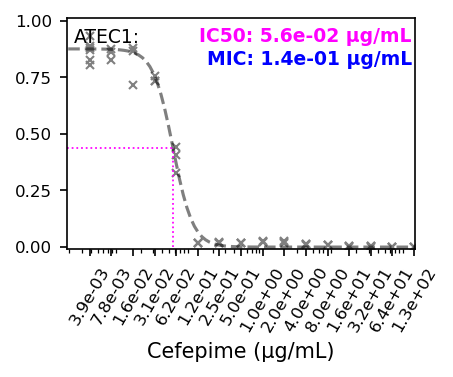

In [23]:
fig, ax = plt.subplots(figsize=(3, 2), dpi=150)
plategig.static.plot_dose_response_curve_fit(df_analysis,
                                              strain='ATEC1',
                                              antibiotic='Cefepime',
                                              growth_features=growth_features,
                                              strain_colors={},
                                              ax=ax)
fig.savefig(PROJECT_PATH / PROJECT_ID / 'figures/ATEC-1 IC50 fit.png', dpi=300, bbox_inches='tight')

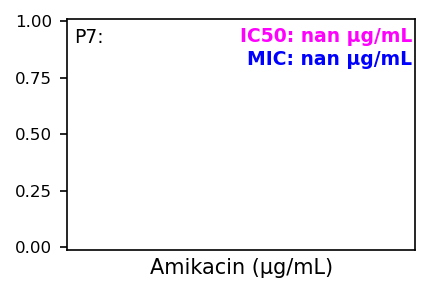

In [24]:
fig, ax = plt.subplots(figsize=(3, 2), dpi=150)
plategig.static.plot_dose_response_curve_fit(df_analysis,
                                              strain='P7',
                                              antibiotic='Amikacin',
                                              growth_features=growth_features,
                                              strain_colors={},
                                              ax=ax)

In [21]:
strains = list(set(df_analysis['Strain'].str.lower()) - set(['media only', 'cells only', np.nan]))
print(strains)

['atec2', 'atec-c4', 'atec-c2', 'atec-c5', 'atec-c6', 'atec4', 'atec1', 'atec-c1', 'atec6', 'atec3', 'atec-c-r1', 'atec-c3', 'atec5']


In [22]:
antibiotics = list(set(df_analysis['Antibiotic'].str.lower()) - set(['media only', 'cells only', np.nan]))
antibiotics

['cefepime', 'amikacin', 'levofloxacin']

In [23]:
strain_colors = {strain:color for strain, color in zip(strains, sns.color_palette('muted')[:len(strains)])}


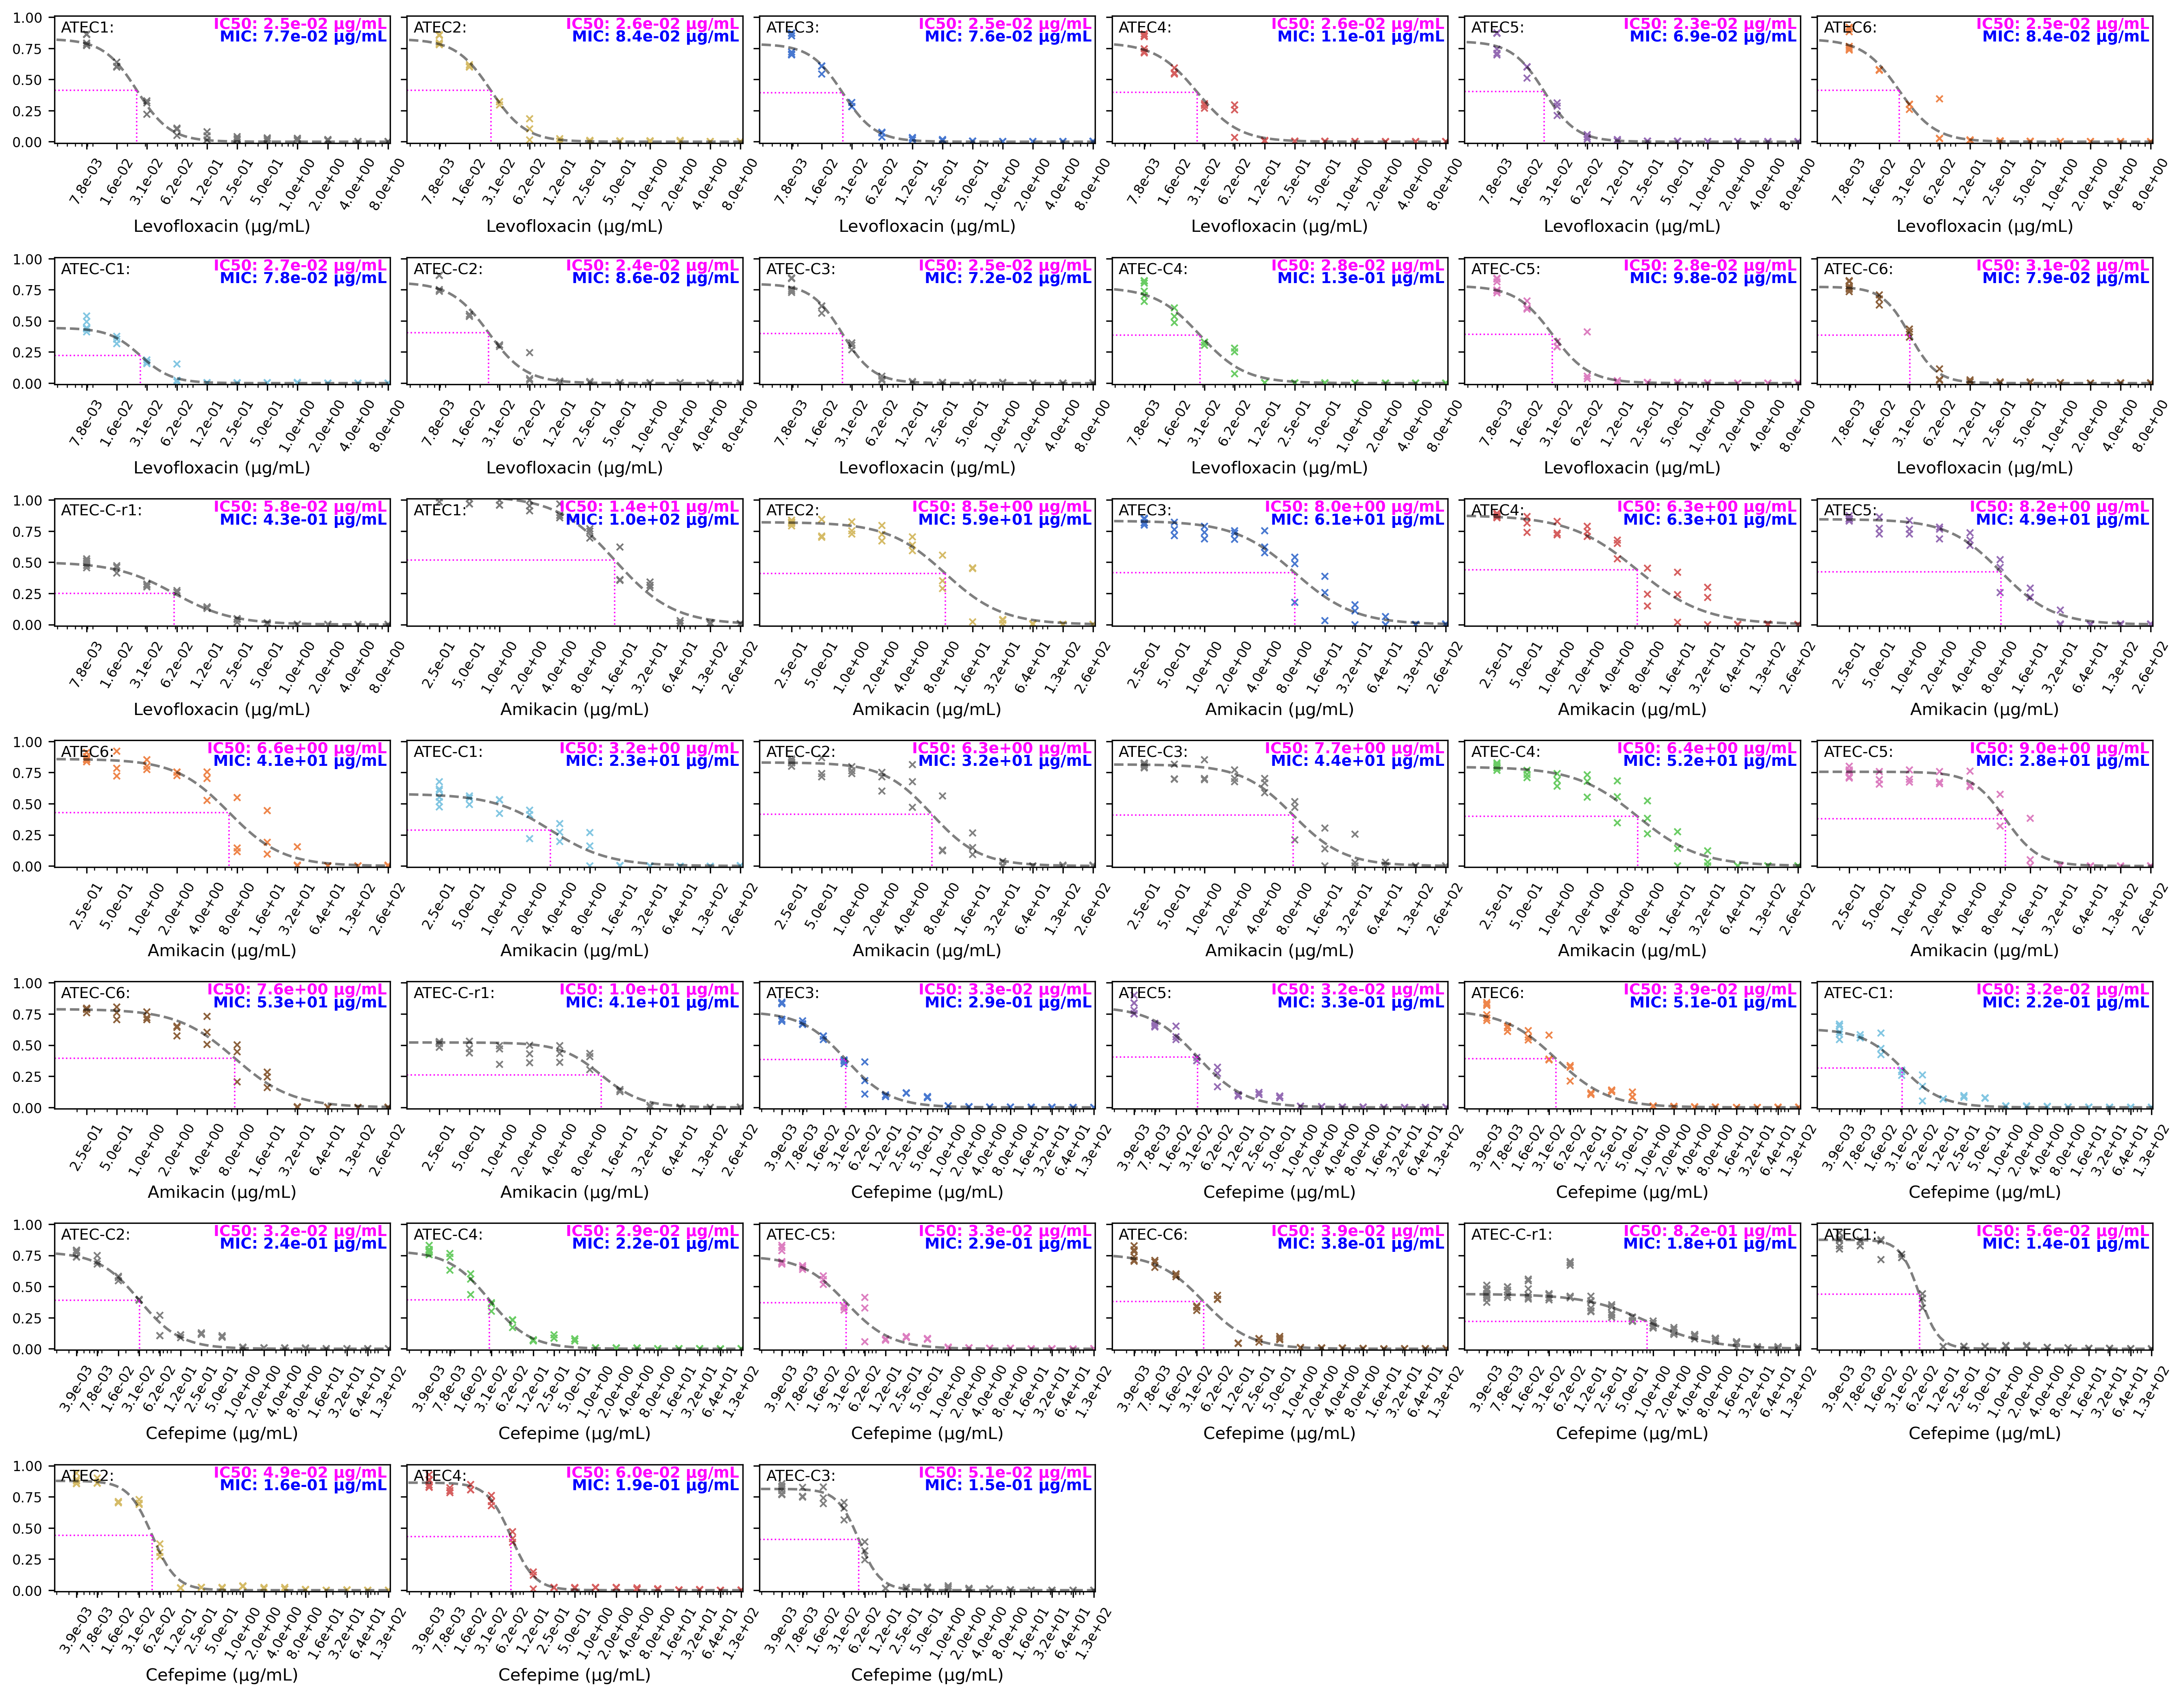

In [28]:
num_drugs = growth_features['Antibiotic'].nunique()
num_experiments = growth_features.shape[0]
num_cols = 6
num_rows = num_experiments//num_cols + (num_experiments % num_cols > 0)
# num_cols = num_experiments//num_drugs
# fig, axes = plt.subplots(num_experiments//num_replicates, num_replicates,
#                        figsize=(num_replicates*3, num_experiments*2), dpi=90)
fig, axes = plt.subplots(num_rows, num_cols,
                       figsize=(num_cols*3, num_rows*2), dpi=300)

for ix, row in growth_features.iterrows():
    plategig.static.plot_dose_response_curve_fit(df_analysis,
                                                growth_features=growth_features,
                                                strain_colors=strain_colors,
                                                strain=row['Strain'],
                                                antibiotic=row['Antibiotic'],
                                                ax=axes.flat[ix])
    
    if row['Status'] == 'FAIL':
        axes.flat[ix].text(0.5, 0.5, f'FAIL', color='red', fontsize=12, fontweight='bold',
                        ha='center', va='center', transform=axes.flat[ix].transAxes)
        # gray out the entire axes
        axes.flat[ix].set_facecolor('lightgray')
    if ix % num_cols != 0:
        axes.flat[ix].set_yticklabels([])
# Hide the rest of the axes
for ix in range(num_experiments, num_cols*num_rows):
    axes.flat[ix].axis('off')
    
fig.tight_layout()
# set empty space between subplots
fig.subplots_adjust(wspace=0.05)
fig.savefig(PROJECT_PATH / PROJECT_ID / 'figures' / f'IC50 fits ATEC.png', dpi=300, bbox_inches='tight')

In [29]:
#### Graphes the IC50 values for each with a confindence interval
    ### looks like it pulls growth_features

final_chart = alt.vconcat()
for drug in sorted(growth_features['Antibiotic'].unique()):
    select_cols = ['Strain','Antibiotic','Status','IC50','IC50_ci_lower','IC50_ci_upper', 'insufficient_drug']
    filtered_growth_features = growth_features[select_cols]
    filtered_growth_features = filtered_growth_features.query(f'Antibiotic == "{drug}" & Status == "PASS"')
    filtered_growth_features['StrainGroup'] = filtered_growth_features['Strain'].str.extract(r'(\D+)')

    base = alt.Chart(filtered_growth_features).encode(
        x='Strain',
    ).properties(width=700, height=300)

    ic50 = base.encode(
        y=alt.Y('IC50:Q', scale=alt.Scale(type="log")),
        color=alt.Color("StrainGroup:N")
    ).mark_point(filled=True, size=200)

    error_bars = base.mark_errorbar(ticks=True, size=10, thickness=2).encode(
        alt.Y("IC50_ci_lower:Q", scale=alt.Scale(type="log")).title('IC50'),
        alt.Y2("IC50_ci_upper:Q"),
        color='StrainGroup'
    )

    # Create a dagger symbol on the bars with insufficient_drug flag is true
    dagger = base.mark_text(align='center', baseline='middle', fontSize=14, color='black', fontWeight='bold', dy=-20, dx=0).encode(
        y=alt.Y('IC50'),
        text=alt.condition(
            alt.datum.insufficient_drug, if_true=alt.value("‡"), if_false=alt.value("")
            )
    )

    layered_chart = alt.layer(ic50, error_bars, dagger).properties(title=drug)
    final_chart &= layered_chart

final_chart = final_chart.resolve_scale(y='independent', x='independent').configure_axis(
    labelFontSize=18,
    titleFontSize=18,
).configure_title(
    fontSize=18,
    anchor='middle',
).configure_legend(
    titleFontSize=18,
    labelFontSize=18,
    symbolLimit=50,
)

final_chart = final_chart.configure_title(anchor='middle')
final_chart.save(PROJECT_PATH / PROJECT_ID / 'figures' / f'IC50 combined ATEC.png', scale_factor=2)
final_chart.show()

alt.VConcatChart(...)

In [30]:
#### Graphes the IC50 values for each with a confindence interval
    ### looks like it pulls growth_features
# Index(['Strain', 'Antibiotic', 'Status', 'IC50', 'MIC', 'IC50_ci_lower',
#        'IC50_ci_upper', 'MIC_ci_lower', 'MIC_ci_upper', 'max_growth',
#        'hill_coeff', 'ic50_threshold', 'mic_threshold', 'x_fit', 'y_fit',
#        'ic50_bootstrap', 'insufficient_drug'],
#       dtype='object')


final_chart = alt.vconcat()
for drug in sorted(growth_features['Antibiotic'].unique()):
    select_cols = ['Strain','Antibiotic','Status','MIC','MIC_ci_lower','MIC_ci_upper', 'insufficient_drug']
    filtered_growth_features = growth_features[select_cols]
    filtered_growth_features = filtered_growth_features.query(f'Antibiotic == "{drug}" & Status == "PASS"')
    filtered_growth_features['StrainGroup'] = filtered_growth_features['Strain'].str.extract(r'(\D+)')

    base = alt.Chart(filtered_growth_features).encode(
        x='Strain',
    ).properties(width=700, height=300)

    MIC = base.encode(
        y=alt.Y('MIC:Q', scale=alt.Scale(type="log")),
        color=alt.Color("StrainGroup:N")
    ).mark_point(filled=True, size=200)

    error_bars = base.mark_errorbar(ticks=True, size=10, thickness=2).encode(
        alt.Y("MIC_ci_lower:Q", scale=alt.Scale(type="log")).title('MIC'),
        alt.Y2("MIC_ci_upper:Q"),
        color='StrainGroup'
    )

    # Create a dagger symbol on the bars with insufficient_drug flag is true
    dagger = base.mark_text(align='center', baseline='middle', fontSize=14, color='black', fontWeight='bold', dy=-20, dx=0).encode(
        y=alt.Y('MIC'),
        text=alt.condition(
            alt.datum.insufficient_drug, if_true=alt.value("‡"), if_false=alt.value("")
            )
    )

    layered_chart = alt.layer(MIC, error_bars, dagger).properties(title=drug)
    final_chart &= layered_chart

final_chart = final_chart.resolve_scale(y='independent', x='independent').configure_axis(
    labelFontSize=18,
    titleFontSize=18,
).configure_title(
    fontSize=18,
    anchor='middle',
).configure_legend(
    titleFontSize=18,
    labelFontSize=18,
    symbolLimit=50,
)

final_chart = final_chart.configure_title(anchor='middle')
final_chart.save(PROJECT_PATH / PROJECT_ID / 'figures' / f'MIC combined ATEC.png', scale_factor=2)
final_chart.show()

alt.VConcatChart(...)

In [31]:
(
growth_features[['Antibiotic','Strain','Status','IC50','MIC','IC50_ci_lower','IC50_ci_upper', 'max_growth', 'hill_coeff']]
.to_csv(PROJECT_PATH / PROJECT_ID / 'figures' / f'IC50 estimations.csv',
          index=False)
)

Standard Deviations for each group and antibiotic:
      group    Antibiotic  mean_IC50   sd_IC50
0      ATEC      Amikacin   8.644461  2.874654
1      ATEC      Cefepime   0.044899  0.011739
2      ATEC  Levofloxacin   0.025002  0.001067
3    ATEC-C      Amikacin   6.690309  1.978548
4    ATEC-C      Cefepime   0.036045  0.008067
5    ATEC-C  Levofloxacin   0.027328  0.002542
6  ATEC-C-r      Amikacin  10.378020       NaN
7  ATEC-C-r      Cefepime   0.819900       NaN
8  ATEC-C-r  Levofloxacin   0.058469       NaN


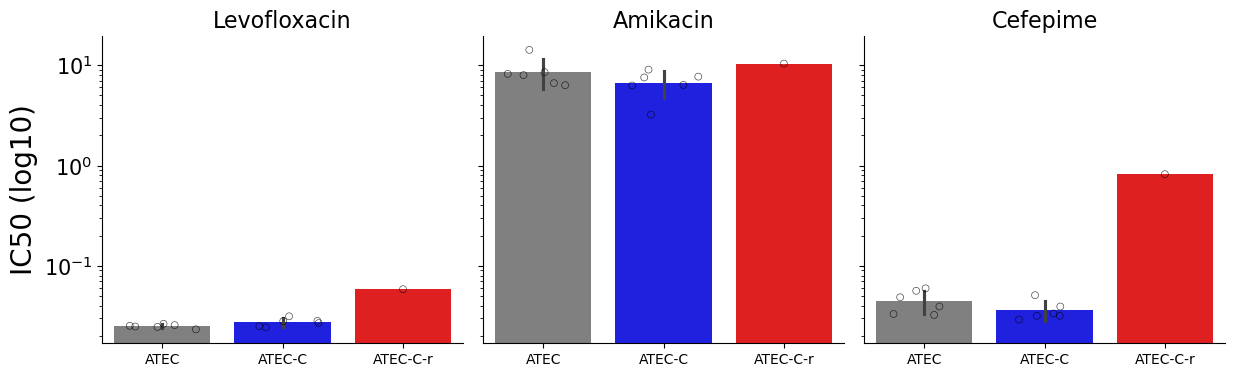

In [27]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming growth_features DataFrame is already defined
# Extract 'group' from 'Strain' based on the pattern
growth_features['group'] = growth_features['Strain'].apply(lambda x: re.split(r'[1-9]', x)[0])

# Calculate means and SDs
summary_stats = (
    growth_features.groupby(['group', 'Antibiotic'])
    .agg(mean_IC50=('IC50', 'mean'), sd_IC50=('IC50', 'std'))
    .reset_index()
)

# Display the calculated standard deviation values
print("Standard Deviations for each group and antibiotic:")
print(summary_stats)

group_palette = {
    "ATEC": "grey",
    "ATEC-C": "blue",   # Blue
    "ATEC-C-r": "red",   # Green
    # Add more groups and colors as needed
}

# Create the facetted barplot
g = sns.catplot(
    data=growth_features, 
    kind="bar", 
    x="group", 
    y="IC50", 
    col="Antibiotic", 
    ci="sd", 
    palette=group_palette, 
    height=4, 
    aspect=1
)

# Overlay the individual data points with optimized spread and grey color
for ax, antibiotic in zip(g.axes.flat, growth_features['Antibiotic'].unique()):
    sns.stripplot(
        data=growth_features[growth_features['Antibiotic'] == antibiotic],
        x="group",
        y="IC50",
        color="black",     # Set individual points to black
        facecolor="none",
        dodge=False,      # Disable dodge to better control jitter within each bar
        ax=ax,
        alpha=0.7,        # Slightly increase transparency
        jitter=0.3,       # Increase jitter for better spread within each group
        marker="o",
        edgecolor="gray",
        linewidth=0.5,
        legend=False      # Remove legend from stripplot
    )
    ax.set_yscale("log")  # Set y-axis to log10 scale for each subplot

# Set axis labels and titles
g.set_axis_labels("Group", "IC50 (log 10 scale)")
g.set_titles("{col_name}")

for ax in g.axes.flat:
    ax.set_xlabel("", fontsize=14)       # Set larger x-axis label
    ax.set_ylabel("IC50 (log10)", fontsize=20)  # Set larger y-axis label
    ax.title.set_size(16)  # Set larger title for each facet
    ax.tick_params(axis='y', labelsize=15) 

# Save the plot
g.fig.savefig(PROJECT_PATH / PROJECT_ID / 'figures' / f'IC50 combined atec 1112.png', dpi=200, bbox_inches='tight')

# Display the plot
plt.show()


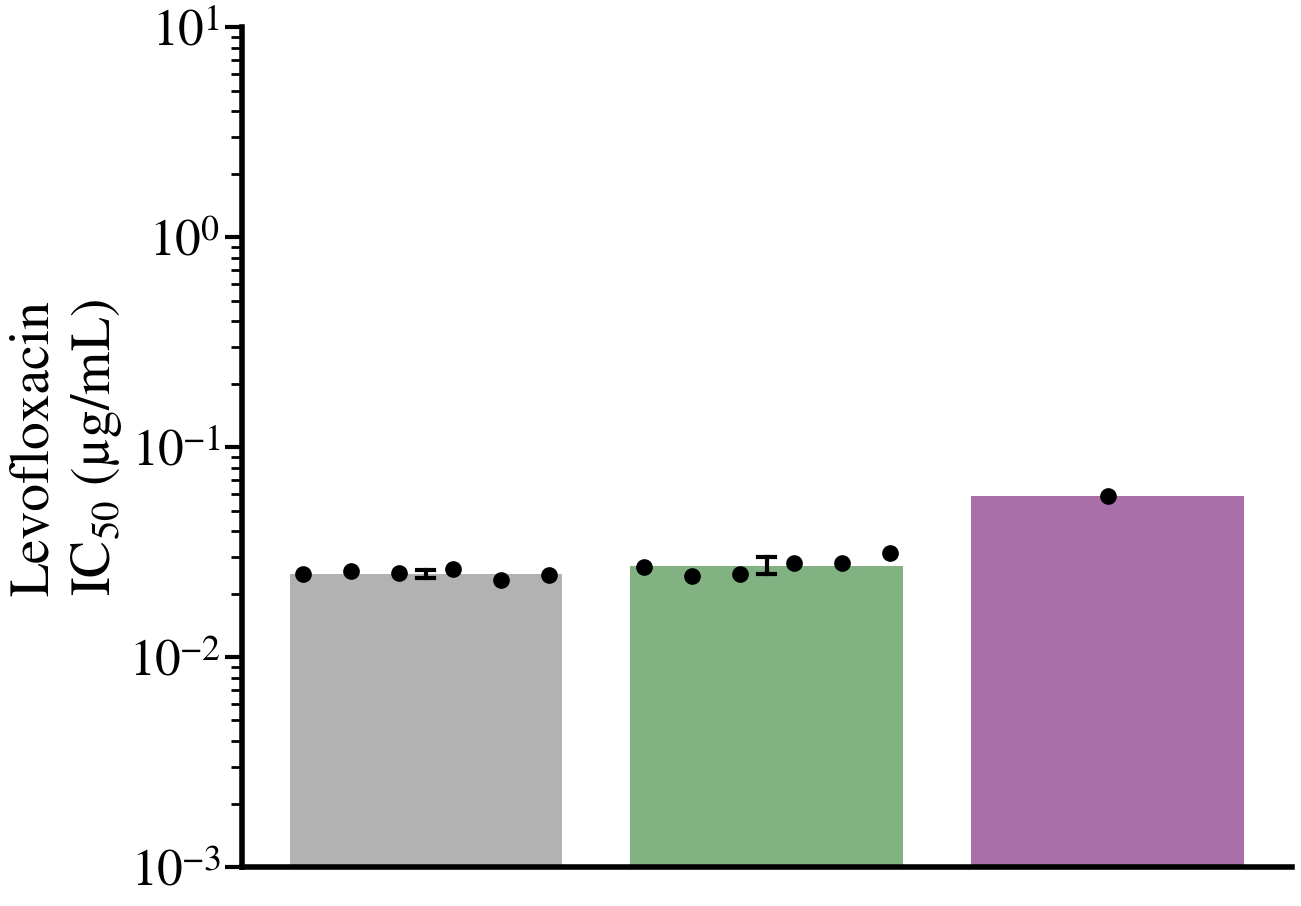

In [32]:
import re
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Nimbus Roman"
plt.rcParams["mathtext.fontset"] = "custom"
plt.rcParams["mathtext.rm"] = "Nimbus Roman"


########## NO LABELS

# Assign the antibiotic you want to graph
selected_antibiotic = "Levofloxacin"

# Subset the data for the selected antibiotic
subset_data = growth_features[growth_features['Antibiotic'] == selected_antibiotic].copy()  # Avoid SettingWithCopyWarning

# Custom y-axis limits for each antibiotic
custom_y_limits = {
    "Levofloxacin": (0.001, 10),
    "Amikacin": (.1, 1000),
    "Cefepime": (0.001, 10)
}

# Create a new column for the updated group labels
def assign_group_label(row):
    if row['group'] == "ATEC":
        return r"Pb"  # Just MG
    elif row['group'] == "ATEC-C":
        return r"Pb$^{\mathrm{CEF}}$"  # MG with AMI as superscript
    elif row['group'] == "ATEC-C-r":
        return r"Pb$^{\mathrm{CEF-R}}$"  # MG with AMI as superscript
    else:
        return "Unknown"

# Ensure the 'group' column exists
if 'group' not in subset_data.columns:
    subset_data['group'] = growth_features['Strain'].apply(lambda x: re.split(r'[1-9]', x)[0])

# Apply the function to create the new column
subset_data.loc[:, 'group_fancy'] = subset_data.apply(assign_group_label, axis=1)

# Update the palette to match the new group labels
group_palette = {
    r"Pb": "grey",
    r"Pb$^{\mathrm{CEF}}$": "forestgreen",
    r"MG": "grey",
    r"Pb$^{\mathrm{CEF-R}}$": "purple",
}

# Use FacetGrid for plotting
# Use FacetGrid for plotting
g = sns.FacetGrid(
    subset_data,
    col="Antibiotic",  # Facet by Antibiotic
    sharey=False,  # Allow independent y-axis scaling
    height=10,  # Height of each facet
    aspect=1.5,  # Aspect ratio for width scaling
)

# Map bar plots to the grid
g.map(
    sns.barplot,
    "group_fancy",  # X-axis
    "IC50",  # Y-axis
    ci="sd",
    order=subset_data['group_fancy'].unique(),  # Ensure consistent x-axis order
    palette=group_palette,
    alpha=0.6,
    errcolor="black",  # Color of the error bars
    errwidth=3,  # Thickness of the error bars
    capsize=0.05  # Length of the caps on error bars
)

# Custom function to calculate evenly spaced x-positions
def get_evenly_spaced_positions(group_data, x_base, spread=0.36, gap=0.08):
    """
    Calculate evenly spaced x-positions around a central x_base, leaving a gap in the middle.

    Parameters:
        group_data: DataFrame containing points for a single category.
        x_base: Central x position for the category.
        spread: Maximum range to spread points around the center.
        gap: The size of the gap to leave in the middle (default: 0.1).

    Returns:
        List of adjusted x-positions for the points.
    """
    n_points = len(group_data)
    if n_points == 1:
        return [x_base]  # No need to spread if there's only one point

    half_points = n_points // 2  # Divide points into two halves
    if n_points % 2 == 0:
        # Even number of points
        left_offsets = np.linspace(-spread, -gap, half_points)
        right_offsets = np.linspace(gap, spread, half_points)
        offsets = np.concatenate([left_offsets, right_offsets])
    else:
        # Odd number of points: one point stays at the center
        left_offsets = np.linspace(-spread, -gap, half_points)
        right_offsets = np.linspace(gap, spread, half_points)
        center_offset = [0]  # Keep one point at the exact center
        offsets = np.concatenate([left_offsets, center_offset, right_offsets])

    return x_base + offsets

# Overlay strip plots with custom spacing
for group_fancy, group_data in subset_data.groupby('group_fancy'):
    x_base = subset_data['group_fancy'].unique().tolist().index(group_fancy)  # Base x position
    x_positions = get_evenly_spaced_positions(group_data, x_base)
    
    g.ax.scatter(
        x_positions,
        group_data['IC50'],
        color="black",
        facecolor="black",
        s=100,
        edgecolor="black",
        linewidth=2,
        zorder=10  # Ensure points are above other plot elements
    )


# Customizations for the y-axis and ticks
for ax in g.axes.flat:
    ax.set_yscale("log")  # Set log scale

    # Let Seaborn/Matplotlib determine y-ticks automatically and just adjust their font size
    

    # Apply custom y-axis limits for the selected antibiotic
    if selected_antibiotic in custom_y_limits:
        ax.set_ylim(custom_y_limits[selected_antibiotic])

    ax.set_xticks([])  # Remove tick positions
    ax.set_xticklabels([])  # Remove tick labels
    # ax.set_yticks([0.001, 0.01, 0.1, 1])
    # Remove x-axis label
    ax.set_xlabel('')  # Remove x-axis label
    for spine in ax.spines.values():
        spine.set_linewidth(4)  # Set thickness of the spine lines

    ax.tick_params(axis='both', which='major', length=12, width=3)  # Major ticks
    ax.tick_params(axis='both', which='minor', length=8, width=2)  # Minor ticks
    for label in ax.get_yticklabels():
        label.set_fontsize(37)  # Adjust font size for existing tick labels

# Add axis labels and facet titles
g.set_axis_labels("", "", fontsize=40)
g.set_axis_labels("", f"{selected_antibiotic}\nIC$_{{50}}$ (μg/mL)", fontsize=40)
g.set_titles("", size=50)  # Facet title uses the column value

# Adjust overall layout and spacing
g.fig.subplots_adjust(left=0.2, right=0.9, top=0.9, wspace=0.3, hspace=0.4)
g.fig.set_size_inches(15, 10)  # Total figure size

# Save the plot (optional)
#g.savefig(f"{selected_antibiotic}_IC50_plot_1127.png", dpi=300, bbox_inches="tight")
g.fig.savefig(PROJECT_PATH / PROJECT_ID / 'figures' /'finals'/'0512_finals' / f"{selected_antibiotic}_Pb_IC50_plot.png", dpi=600, bbox_inches="tight")
#g.fig.savefig(PROJECT_PATH / PROJECT_ID / 'figures' / f'Cefepime_IC50_new', dpi=200, bbox_inches='tight')
# Show the plot
plt.show()


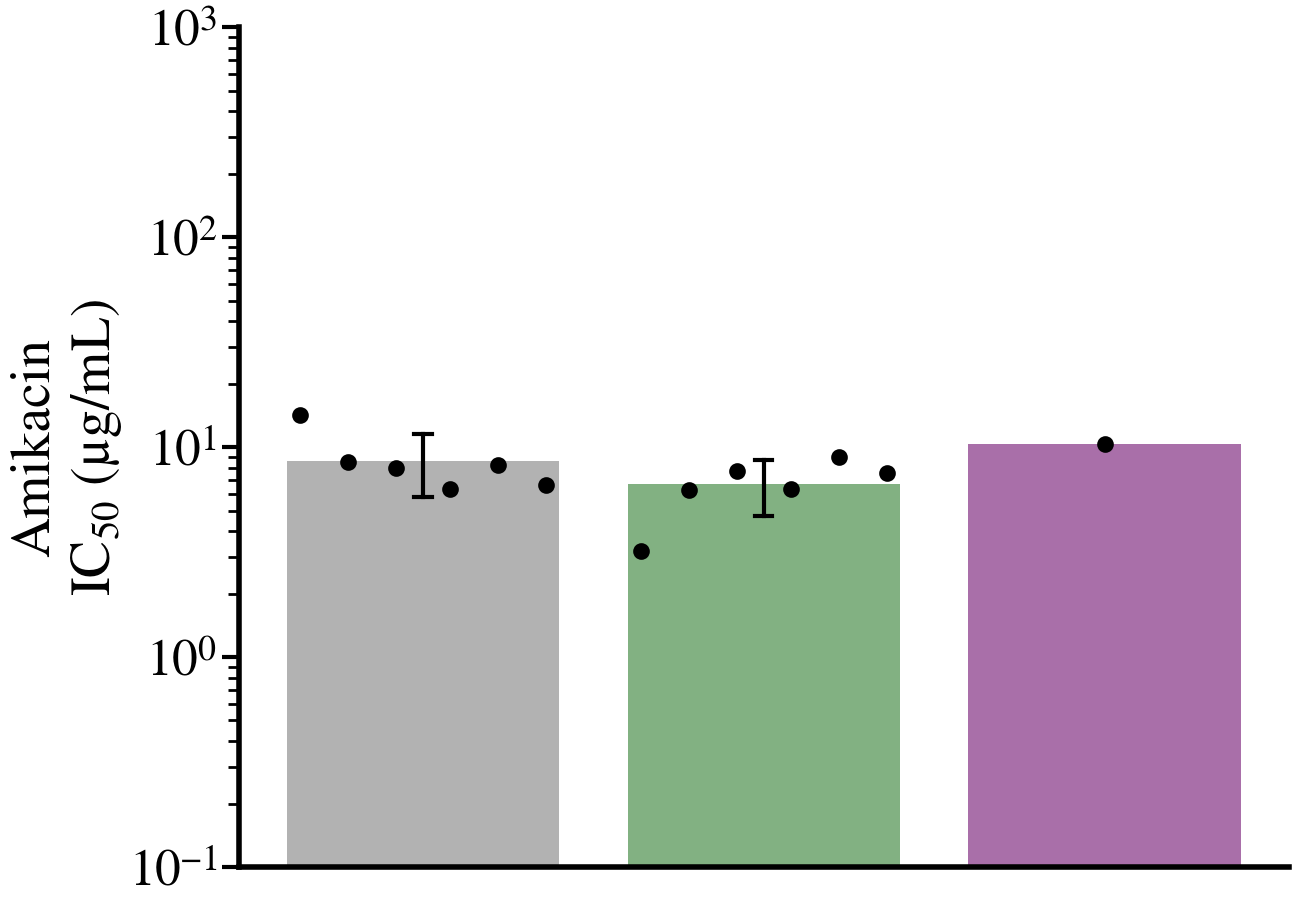

In [33]:
import re
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Nimbus Roman"
plt.rcParams["mathtext.fontset"] = "custom"
plt.rcParams["mathtext.rm"] = "Nimbus Roman"


########## NO LABELS

# Assign the antibiotic you want to graph
selected_antibiotic = "Amikacin"

# Subset the data for the selected antibiotic
subset_data = growth_features[growth_features['Antibiotic'] == selected_antibiotic].copy()  # Avoid SettingWithCopyWarning

# Custom y-axis limits for each antibiotic
custom_y_limits = {
    "Levofloxacin": (0.001, 10),
    "Amikacin": (.1, 1000),
    "Cefepime": (0.001, 10)
}

# Create a new column for the updated group labels
def assign_group_label(row):
    if row['group'] == "ATEC":
        return r"Pb"  # Just MG
    elif row['group'] == "ATEC-C":
        return r"Pb$^{\mathrm{CEF}}$"  # MG with AMI as superscript
    elif row['group'] == "ATEC-C-r":
        return r"Pb$^{\mathrm{CEF-R}}$"  # MG with AMI as superscript
    else:
        return "Unknown"

# Ensure the 'group' column exists
if 'group' not in subset_data.columns:
    subset_data['group'] = growth_features['Strain'].apply(lambda x: re.split(r'[1-9]', x)[0])

# Apply the function to create the new column
subset_data.loc[:, 'group_fancy'] = subset_data.apply(assign_group_label, axis=1)

# Update the palette to match the new group labels
group_palette = {
    r"Pb": "grey",
    r"Pb$^{\mathrm{CEF}}$": "forestgreen",
    r"MG": "grey",
    r"Pb$^{\mathrm{CEF-R}}$": "purple",
}

# Use FacetGrid for plotting
# Use FacetGrid for plotting
g = sns.FacetGrid(
    subset_data,
    col="Antibiotic",  # Facet by Antibiotic
    sharey=False,  # Allow independent y-axis scaling
    height=10,  # Height of each facet
    aspect=1.5,  # Aspect ratio for width scaling
)

# Map bar plots to the grid
g.map(
    sns.barplot,
    "group_fancy",  # X-axis
    "IC50",  # Y-axis
    ci="sd",
    order=subset_data['group_fancy'].unique(),  # Ensure consistent x-axis order
    palette=group_palette,
    alpha=0.6,
    errcolor="black",  # Color of the error bars
    errwidth=3,  # Thickness of the error bars
    capsize=0.05  # Length of the caps on error bars
)

# Custom function to calculate evenly spaced x-positions
def get_evenly_spaced_positions(group_data, x_base, spread=0.36, gap=0.08):
    """
    Calculate evenly spaced x-positions around a central x_base, leaving a gap in the middle.

    Parameters:
        group_data: DataFrame containing points for a single category.
        x_base: Central x position for the category.
        spread: Maximum range to spread points around the center.
        gap: The size of the gap to leave in the middle (default: 0.1).

    Returns:
        List of adjusted x-positions for the points.
    """
    n_points = len(group_data)
    if n_points == 1:
        return [x_base]  # No need to spread if there's only one point

    half_points = n_points // 2  # Divide points into two halves
    if n_points % 2 == 0:
        # Even number of points
        left_offsets = np.linspace(-spread, -gap, half_points)
        right_offsets = np.linspace(gap, spread, half_points)
        offsets = np.concatenate([left_offsets, right_offsets])
    else:
        # Odd number of points: one point stays at the center
        left_offsets = np.linspace(-spread, -gap, half_points)
        right_offsets = np.linspace(gap, spread, half_points)
        center_offset = [0]  # Keep one point at the exact center
        offsets = np.concatenate([left_offsets, center_offset, right_offsets])

    return x_base + offsets

# Overlay strip plots with custom spacing
for group_fancy, group_data in subset_data.groupby('group_fancy'):
    x_base = subset_data['group_fancy'].unique().tolist().index(group_fancy)  # Base x position
    x_positions = get_evenly_spaced_positions(group_data, x_base)
    
    g.ax.scatter(
        x_positions,
        group_data['IC50'],
        color="black",
        facecolor="black",
        s=100,
        edgecolor="black",
        linewidth=2,
        zorder=10  # Ensure points are above other plot elements
    )


# Customizations for the y-axis and ticks
for ax in g.axes.flat:
    ax.set_yscale("log")  # Set log scale

    # Let Seaborn/Matplotlib determine y-ticks automatically and just adjust their font size
    

    # Apply custom y-axis limits for the selected antibiotic
    if selected_antibiotic in custom_y_limits:
        ax.set_ylim(custom_y_limits[selected_antibiotic])

    ax.set_xticks([])  # Remove tick positions
    ax.set_xticklabels([])  # Remove tick labels
    # ax.set_yticks([0.001, 0.01, 0.1, 1])
    # Remove x-axis label
    ax.set_xlabel('')  # Remove x-axis label
    for spine in ax.spines.values():
        spine.set_linewidth(4)  # Set thickness of the spine lines

    ax.tick_params(axis='both', which='major', length=12, width=3)  # Major ticks
    ax.tick_params(axis='both', which='minor', length=8, width=2)  # Minor ticks
    for label in ax.get_yticklabels():
        label.set_fontsize(37)  # Adjust font size for existing tick labels

# Add axis labels and facet titles
g.set_axis_labels("", "", fontsize=40)
g.set_axis_labels("", f"{selected_antibiotic}\nIC$_{{50}}$ (μg/mL)", fontsize=40)
g.set_titles("", size=50)  # Facet title uses the column value

# Adjust overall layout and spacing
g.fig.subplots_adjust(left=0.2, right=0.9, top=0.9, wspace=0.3, hspace=0.4)
g.fig.set_size_inches(15, 10)  # Total figure size

# Save the plot (optional)
#g.savefig(f"{selected_antibiotic}_IC50_plot_1127.png", dpi=300, bbox_inches="tight")
g.fig.savefig(PROJECT_PATH / PROJECT_ID / 'figures' /'finals'/'0512_finals' / f"{selected_antibiotic}_Pb_IC50_plot.png", dpi=600, bbox_inches="tight")
#g.fig.savefig(PROJECT_PATH / PROJECT_ID / 'figures' / f'Cefepime_IC50_new', dpi=200, bbox_inches='tight')
# Show the plot
plt.show()


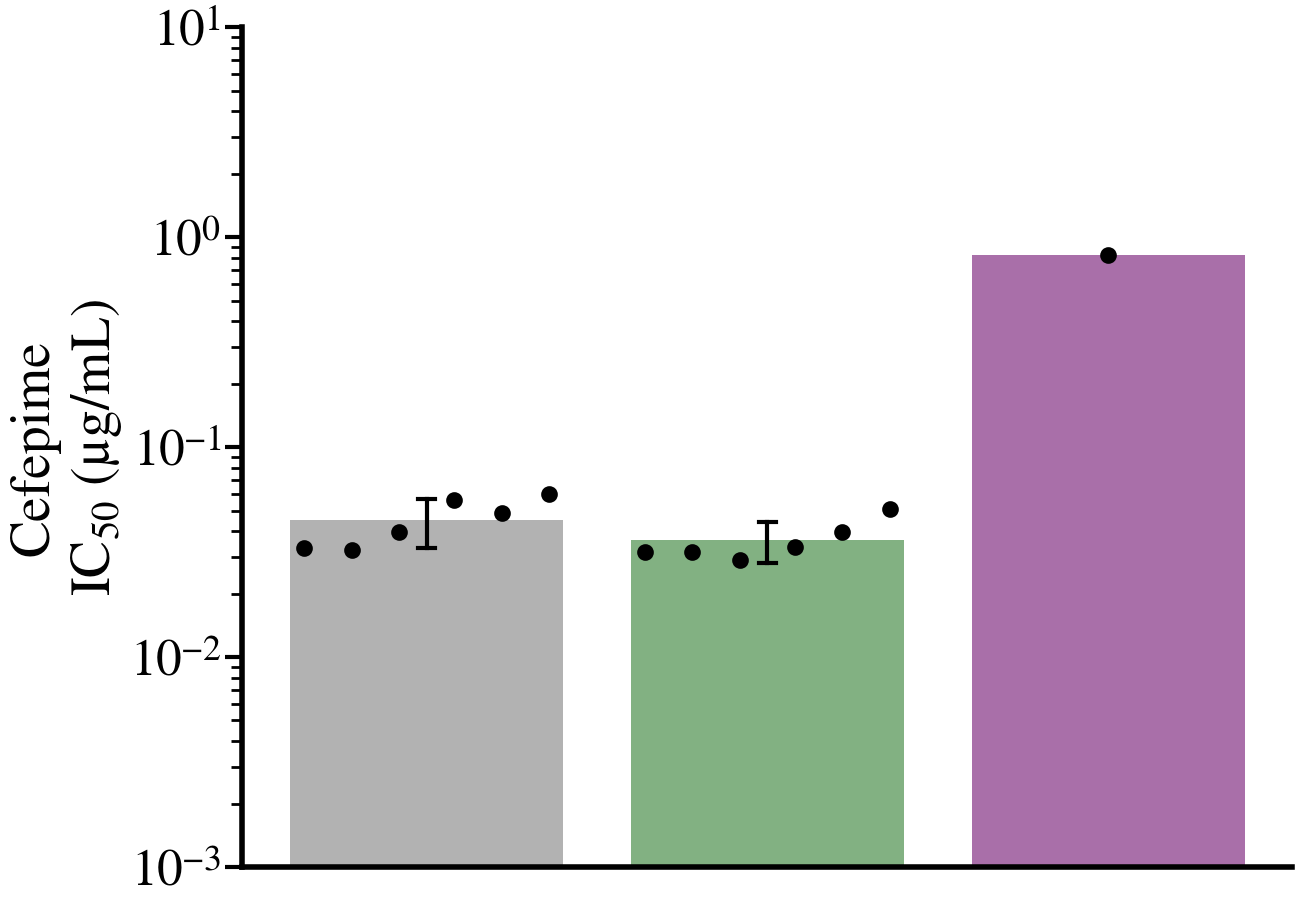

In [34]:
import re
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Nimbus Roman"
plt.rcParams["mathtext.fontset"] = "custom"
plt.rcParams["mathtext.rm"] = "Nimbus Roman"


########## NO LABELS

# Assign the antibiotic you want to graph
selected_antibiotic = "Cefepime"

# Subset the data for the selected antibiotic
subset_data = growth_features[growth_features['Antibiotic'] == selected_antibiotic].copy()  # Avoid SettingWithCopyWarning

# Custom y-axis limits for each antibiotic
custom_y_limits = {
    "Levofloxacin": (0.001, 10),
    "Amikacin": (.1, 1000),
    "Cefepime": (0.001, 10)
}

# Create a new column for the updated group labels
def assign_group_label(row):
    if row['group'] == "ATEC":
        return r"Pb"  # Just MG
    elif row['group'] == "ATEC-C":
        return r"Pb$^{\mathrm{CEF}}$"  # MG with AMI as superscript
    elif row['group'] == "ATEC-C-r":
        return r"Pb$^{\mathrm{CEF-R}}$"  # MG with AMI as superscript
    else:
        return "Unknown"

# Ensure the 'group' column exists
if 'group' not in subset_data.columns:
    subset_data['group'] = growth_features['Strain'].apply(lambda x: re.split(r'[1-9]', x)[0])

# Apply the function to create the new column
subset_data.loc[:, 'group_fancy'] = subset_data.apply(assign_group_label, axis=1)

# Update the palette to match the new group labels
group_palette = {
    r"Pb": "grey",
    r"Pb$^{\mathrm{CEF}}$": "forestgreen",
    r"MG": "grey",
    r"Pb$^{\mathrm{CEF-R}}$": "purple",
}

# Use FacetGrid for plotting
# Use FacetGrid for plotting
g = sns.FacetGrid(
    subset_data,
    col="Antibiotic",  # Facet by Antibiotic
    sharey=False,  # Allow independent y-axis scaling
    height=10,  # Height of each facet
    aspect=1.5,  # Aspect ratio for width scaling
)

# Map bar plots to the grid
g.map(
    sns.barplot,
    "group_fancy",  # X-axis
    "IC50",  # Y-axis
    ci="sd",
    order=subset_data['group_fancy'].unique(),  # Ensure consistent x-axis order
    palette=group_palette,
    alpha=0.6,
    errcolor="black",  # Color of the error bars
    errwidth=3,  # Thickness of the error bars
    capsize=0.05  # Length of the caps on error bars
)

# Custom function to calculate evenly spaced x-positions
def get_evenly_spaced_positions(group_data, x_base, spread=0.36, gap=0.08):
    """
    Calculate evenly spaced x-positions around a central x_base, leaving a gap in the middle.

    Parameters:
        group_data: DataFrame containing points for a single category.
        x_base: Central x position for the category.
        spread: Maximum range to spread points around the center.
        gap: The size of the gap to leave in the middle (default: 0.1).

    Returns:
        List of adjusted x-positions for the points.
    """
    n_points = len(group_data)
    if n_points == 1:
        return [x_base]  # No need to spread if there's only one point

    half_points = n_points // 2  # Divide points into two halves
    if n_points % 2 == 0:
        # Even number of points
        left_offsets = np.linspace(-spread, -gap, half_points)
        right_offsets = np.linspace(gap, spread, half_points)
        offsets = np.concatenate([left_offsets, right_offsets])
    else:
        # Odd number of points: one point stays at the center
        left_offsets = np.linspace(-spread, -gap, half_points)
        right_offsets = np.linspace(gap, spread, half_points)
        center_offset = [0]  # Keep one point at the exact center
        offsets = np.concatenate([left_offsets, center_offset, right_offsets])

    return x_base + offsets

# Overlay strip plots with custom spacing
for group_fancy, group_data in subset_data.groupby('group_fancy'):
    x_base = subset_data['group_fancy'].unique().tolist().index(group_fancy)  # Base x position
    x_positions = get_evenly_spaced_positions(group_data, x_base)
    
    g.ax.scatter(
        x_positions,
        group_data['IC50'],
        color="black",
        facecolor="black",
        s=100,
        edgecolor="black",
        linewidth=2,
        zorder=10  # Ensure points are above other plot elements
    )


# Customizations for the y-axis and ticks
for ax in g.axes.flat:
    ax.set_yscale("log")  # Set log scale

    # Let Seaborn/Matplotlib determine y-ticks automatically and just adjust their font size
    

    # Apply custom y-axis limits for the selected antibiotic
    if selected_antibiotic in custom_y_limits:
        ax.set_ylim(custom_y_limits[selected_antibiotic])

    ax.set_xticks([])  # Remove tick positions
    ax.set_xticklabels([])  # Remove tick labels
    # ax.set_yticks([0.001, 0.01, 0.1, 1])
    # Remove x-axis label
    ax.set_xlabel('')  # Remove x-axis label
    for spine in ax.spines.values():
        spine.set_linewidth(4)  # Set thickness of the spine lines

    ax.tick_params(axis='both', which='major', length=12, width=3)  # Major ticks
    ax.tick_params(axis='both', which='minor', length=8, width=2)  # Minor ticks
    for label in ax.get_yticklabels():
        label.set_fontsize(37)  # Adjust font size for existing tick labels

# Add axis labels and facet titles
g.set_axis_labels("", "", fontsize=40)
g.set_axis_labels("", f"{selected_antibiotic}\nIC$_{{50}}$ (μg/mL)", fontsize=40)
g.set_titles("", size=50)  # Facet title uses the column value

# Adjust overall layout and spacing
g.fig.subplots_adjust(left=0.2, right=0.9, top=0.9, wspace=0.3, hspace=0.4)
g.fig.set_size_inches(15, 10)  # Total figure size

# Save the plot (optional)
#g.savefig(f"{selected_antibiotic}_IC50_plot_1127.png", dpi=300, bbox_inches="tight")
g.fig.savefig(PROJECT_PATH / PROJECT_ID / 'figures' /'finals'/'0512_finals' / f"{selected_antibiotic}_Pb_IC50_plot.png", dpi=600, bbox_inches="tight")
#g.fig.savefig(PROJECT_PATH / PROJECT_ID / 'figures' / f'Cefepime_IC50_new', dpi=200, bbox_inches='tight')
# Show the plot
plt.show()


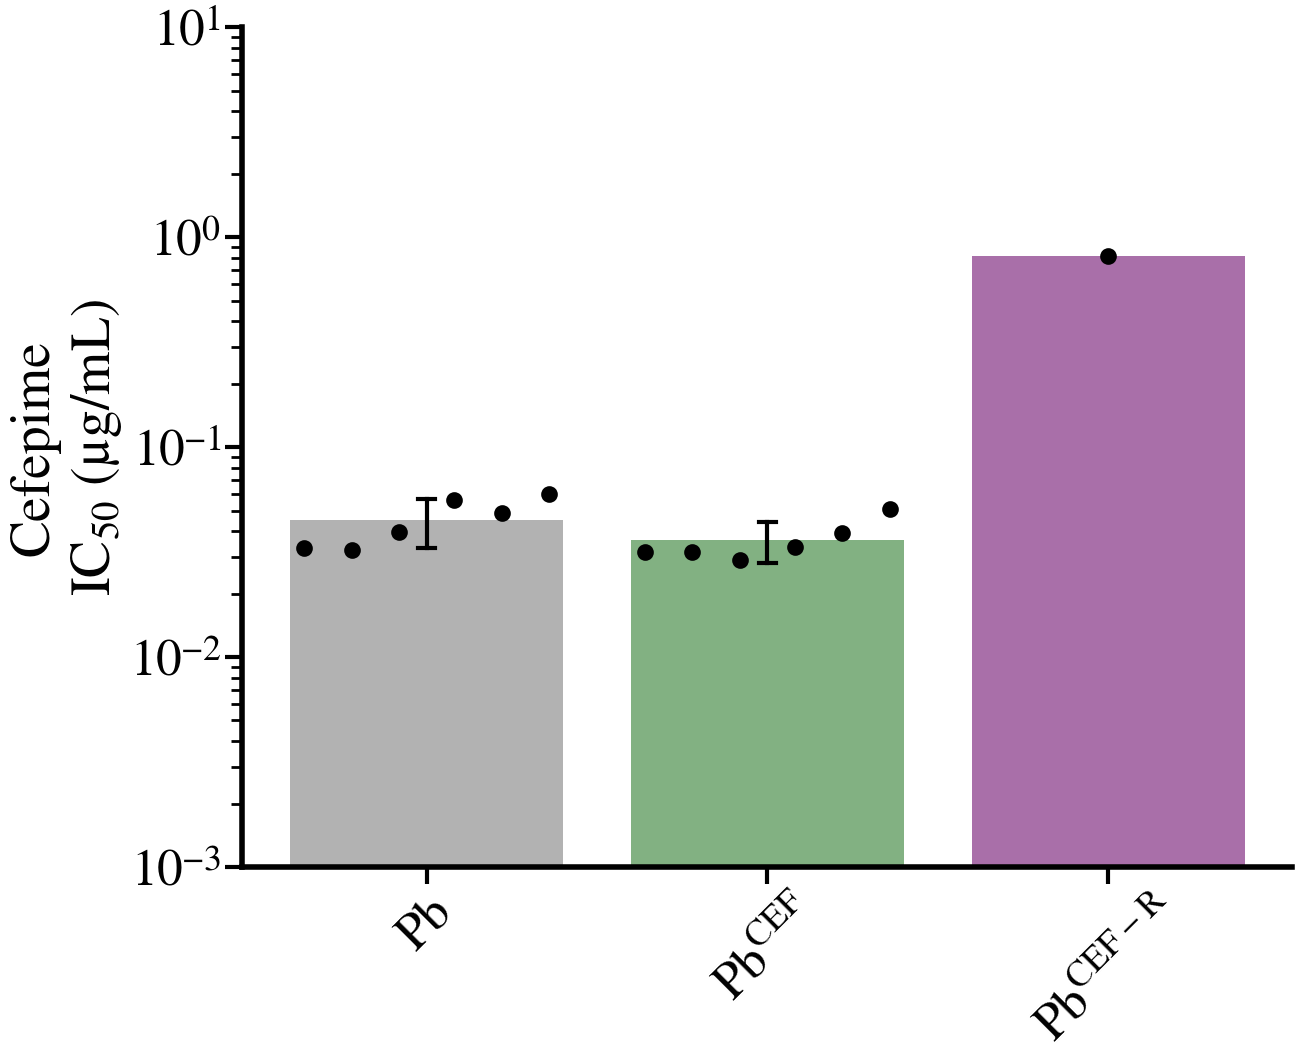

In [35]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Nimbus Roman"
plt.rcParams["mathtext.fontset"] = "custom"
plt.rcParams["mathtext.rm"] = "Nimbus Roman"



# Assign the antibiotic you want to graph
selected_antibiotic = "Cefepime"

# Subset the data for the selected antibiotic
subset_data = growth_features[growth_features['Antibiotic'] == selected_antibiotic].copy()  # Avoid SettingWithCopyWarning

# Custom y-axis limits for each antibiotic
custom_y_limits = {
    "Levofloxacin": (0.001, 10),
    "Amikacin": (.1, 1000),
    "Cefepime": (0.001, 10)
}

# Create a new column for the updated group labels
def assign_group_label(row):
    if row['group'] == "ATEC":
        return r"Pb"  # Just MG
    elif row['group'] == "ATEC-C":
        return r"Pb$^{\mathrm{CEF}}$"  # MG with AMI as superscript
    elif row['group'] == "ATEC-C-r":
        return r"Pb$^{\mathrm{CEF-R}}$"  # MG with AMI as superscript
    else:
        return "Unknown"

# Ensure the 'group' column exists
if 'group' not in subset_data.columns:
    subset_data['group'] = growth_features['Strain'].apply(lambda x: re.split(r'[1-9]', x)[0])

# Apply the function to create the new column
subset_data.loc[:, 'group_fancy'] = subset_data.apply(assign_group_label, axis=1)

# Update the palette to match the new group labels
group_palette = {
    r"Pb": "grey",
    r"Pb$^{\mathrm{CEF}}$": "forestgreen",
    r"MG": "grey",
    r"Pb$^{\mathrm{CEF-R}}$": "purple",
}

g = sns.FacetGrid(
    subset_data,
    col="Antibiotic",  # Facet by Antibiotic
    sharey=False,  # Allow independent y-axis scaling
    height=10,  # Height of each facet
    aspect=1.5,  # Aspect ratio for width scaling
)

# Map bar plots to the grid
g.map(
    sns.barplot,
    "group_fancy",  # X-axis
    "IC50",  # Y-axis
    ci="sd",
    order=subset_data['group_fancy'].unique(),  # Ensure consistent x-axis order
    palette=group_palette,
    alpha=0.6,
    errcolor="black",  # Color of the error bars
    errwidth=3,  # Thickness of the error bars
    capsize=0.05  # Length of the caps on error bars
)

# Custom function to calculate evenly spaced x-positions
def get_evenly_spaced_positions(group_data, x_base, spread=0.36, gap=0.08):
    """
    Calculate evenly spaced x-positions around a central x_base, leaving a gap in the middle.

    Parameters:
        group_data: DataFrame containing points for a single category.
        x_base: Central x position for the category.
        spread: Maximum range to spread points around the center.
        gap: The size of the gap to leave in the middle (default: 0.1).

    Returns:
        List of adjusted x-positions for the points.
    """
    n_points = len(group_data)
    if n_points == 1:
        return [x_base]  # No need to spread if there's only one point

    half_points = n_points // 2  # Divide points into two halves
    if n_points % 2 == 0:
        # Even number of points
        left_offsets = np.linspace(-spread, -gap, half_points)
        right_offsets = np.linspace(gap, spread, half_points)
        offsets = np.concatenate([left_offsets, right_offsets])
    else:
        # Odd number of points: one point stays at the center
        left_offsets = np.linspace(-spread, -gap, half_points)
        right_offsets = np.linspace(gap, spread, half_points)
        center_offset = [0]  # Keep one point at the exact center
        offsets = np.concatenate([left_offsets, center_offset, right_offsets])

    return x_base + offsets

# Overlay strip plots with custom spacing
for group_fancy, group_data in subset_data.groupby('group_fancy'):
    x_base = subset_data['group_fancy'].unique().tolist().index(group_fancy)  # Base x position
    x_positions = get_evenly_spaced_positions(group_data, x_base)
    
    g.ax.scatter(
        x_positions,
        group_data['IC50'],
        color="black",
        facecolor="black",
        s=100,
        edgecolor="black",
        linewidth=2,
        zorder=10  # Ensure points are above other plot elements
    )



# Customizations for the y-axis and ticks
for ax in g.axes.flat:
    ax.set_yscale("log")  # Set log scale

    # Let Seaborn/Matplotlib determine y-ticks automatically and just adjust their font size
    for label in ax.get_yticklabels():
        label.set_fontsize(37)  # Adjust font size for existing tick labels

    # Apply custom y-axis limits for the selected antibiotic
    if selected_antibiotic in custom_y_limits:
        ax.set_ylim(custom_y_limits[selected_antibiotic])

 # Set x-tick positions and labels explicitly
    tick_positions = range(len(subset_data['group_fancy'].unique()))  # Create positions for each category
    ax.set_xticks(tick_positions)  # Set tick positions
    ax.set_xticklabels(subset_data['group_fancy'].unique(), rotation=45, ha="center", fontsize=37) 
    ax.set_yticks([0.001, 0.01, 0.1, 1,10])

    for spine in ax.spines.values():
        spine.set_linewidth(4)  # Set thickness of the spine lines

    ax.tick_params(axis='both', which='major', length=12, width=3)  # Major ticks
    ax.tick_params(axis='both', which='minor', length=8, width=2)  # Minor ticks


# Add axis labels and facet titles
g.set_axis_labels("", "", fontsize=40)
g.set_axis_labels("", f"{selected_antibiotic}\nIC$_{{50}}$ (μg/mL)", fontsize=40)
g.set_titles("", size=50)  # Facet title uses the column value

# Adjust overall layout and spacing
g.fig.subplots_adjust(left=0.2, right=0.9, top=0.9, wspace=0.3, hspace=0.4)
g.fig.set_size_inches(15, 10)  # Total figure size

# Save the plot (optional)
#g.savefig(f"{selected_antibiotic}_IC50_plot_1127.png", dpi=300, bbox_inches="tight")
g.fig.savefig(PROJECT_PATH / PROJECT_ID / 'figures' /'finals'/'0512_finals' / f"{selected_antibiotic}_Pb_IC50_plot_labels.png", dpi=600, bbox_inches="tight")
#g.fig.savefig(PROJECT_PATH / PROJECT_ID / 'figures' / f'Cefepime_IC50_new', dpi=200, bbox_inches='tight')
# Show the plot
plt.show()


In [21]:
import pandas as pd
import itertools
import re
from scipy.stats import ttest_rel

# Assuming growth_features DataFrame is already defined
# Step 1: Create the 'group' and 'culturenumber' columns
growth_features['group'] = growth_features['Strain'].apply(lambda x: re.split(r'[1-9]', x)[0])
growth_features['culturenumber'] = growth_features['Strain'].apply(lambda x: re.search(r'(\d+)', x).group() if re.search(r'(\d+)', x) else None)

# Step 2: Initialize an empty list to store results and get all unique pairs of groups
unique_groups = growth_features['group'].unique()
group_pairs = list(itertools.combinations(unique_groups, 2))  # Generate all unique pairs of groups

# Step 3: Perform paired t-tests for each unique pair of groups within each antibiotic
results = []
for antibiotic in growth_features['Antibiotic'].unique():
    # Filter data by antibiotic
    antibiotic_data = growth_features[growth_features['Antibiotic'] == antibiotic]
    
    for group1, group2 in group_pairs:
        # Filter data for each group
        data1 = antibiotic_data[antibiotic_data['group'] == group1]
        data2 = antibiotic_data[antibiotic_data['group'] == group2]
        
        # Find common culture numbers by using set intersection
        common_culturenumbers = set(data1['culturenumber']).intersection(set(data2['culturenumber']))
        data1_common = data1[data1['culturenumber'].isin(common_culturenumbers)].set_index('culturenumber')
        data2_common = data2[data2['culturenumber'].isin(common_culturenumbers)].set_index('culturenumber')
        
        # Ensure paired data has matching indices (culturenumber)
        if not data1_common.empty and not data2_common.empty:
            ic50_group1 = data1_common['IC50']
            ic50_group2 = data2_common['IC50']
            
            # Perform paired t-test
            t_stat, p_value = ttest_rel(ic50_group1, ic50_group2)
            
            # Append results to list
            results.append({
                'Antibiotic': antibiotic,
                'Group1': group1,
                'Group2': group2,
                't_stat': t_stat,
                'p_value': p_value
            })

# Step 4: Convert results into a DataFrame
sig_growth_features = pd.DataFrame(results)

# Display or save the results
sig_growth_features # Print to check if results are populated


Antibiotic  Group1    Group2    t_stat   p_value
0  Levofloxacin    ATEC    ATEC-C -1.871753  0.120143
1  Levofloxacin    ATEC  ATEC-C-r       NaN       NaN
2  Levofloxacin  ATEC-C  ATEC-C-r       NaN       NaN
3      Amikacin    ATEC    ATEC-C  1.044475  0.344109
4      Amikacin    ATEC  ATEC-C-r       NaN       NaN
5      Amikacin  ATEC-C  ATEC-C-r       NaN       NaN
6      Cefepime    ATEC    ATEC-C  2.694629  0.043060
7      Cefepime    ATEC  ATEC-C-r       NaN       NaN
8      Cefepime  ATEC-C  ATEC-C-r       NaN       NaN

In [22]:
import pandas as pd

# Step 1: Calculate the mean IC50 for each combination of Antibiotic and group
group_means = growth_features.groupby(['Antibiotic', 'group'])['IC50'].mean().reset_index()
group_means = group_means.rename(columns={'IC50': 'mean_IC50'})

# Step 2: Merge the means for Group1 and Group2 into sig_growth_features
sig_growth_features = sig_growth_features.merge(
    group_means, left_on=['Antibiotic', 'Group1'], right_on=['Antibiotic', 'group'], how='left'
).rename(columns={'mean_IC50': 'mean_IC50_Group1'}).drop(columns='group')

sig_growth_features = sig_growth_features.merge(
    group_means, left_on=['Antibiotic', 'Group2'], right_on=['Antibiotic', 'group'], how='left'
).rename(columns={'mean_IC50': 'mean_IC50_Group2'}).drop(columns='group')

# Display the filtered DataFrame
sig_growth_features

Antibiotic  Group1    Group2    t_stat   p_value  mean_IC50_Group1  \
0  Levofloxacin    ATEC    ATEC-C -1.871753  0.120143          0.025002   
1  Levofloxacin    ATEC  ATEC-C-r       NaN       NaN          0.025002   
2  Levofloxacin  ATEC-C  ATEC-C-r       NaN       NaN          0.027328   
3      Amikacin    ATEC    ATEC-C  1.044475  0.344109          8.644461   
4      Amikacin    ATEC  ATEC-C-r       NaN       NaN          8.644461   
5      Amikacin  ATEC-C  ATEC-C-r       NaN       NaN          6.690309   
6      Cefepime    ATEC    ATEC-C  2.694629  0.043060          0.044899   
7      Cefepime    ATEC  ATEC-C-r       NaN       NaN          0.044899   
8      Cefepime  ATEC-C  ATEC-C-r       NaN       NaN          0.036045   

   mean_IC50_Group2  
0          0.027328  
1          0.058469  
2          0.058469  
3          6.690309  
4         10.378020  
5         10.378020  
6          0.036045  
7          0.819900  
8          0.819900

In [23]:
summary_stats = (
    growth_features.groupby(['group', 'Antibiotic'])
    .agg(mean_IC50=('IC50', 'mean'), sd_IC50=('IC50', 'std'))
    .reset_index()
)
summary_stats

group    Antibiotic  mean_IC50   sd_IC50
0      ATEC      Amikacin   8.644461  2.874654
1      ATEC      Cefepime   0.044899  0.011739
2      ATEC  Levofloxacin   0.025002  0.001067
3    ATEC-C      Amikacin   6.690309  1.978548
4    ATEC-C      Cefepime   0.036045  0.008067
5    ATEC-C  Levofloxacin   0.027328  0.002542
6  ATEC-C-r      Amikacin  10.378020       NaN
7  ATEC-C-r      Cefepime   0.819900       NaN
8  ATEC-C-r  Levofloxacin   0.058469       NaN

/tmp/ipykernel_15283/1789075521.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['StrainGroup'] = filtered_data['Strain'].str.extract(r'(\D+)')
/tmp/ipykernel_15283/1789075521.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['SortOrder'] = filtered_data.index
/tmp/ipykernel_15283/1789075521.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

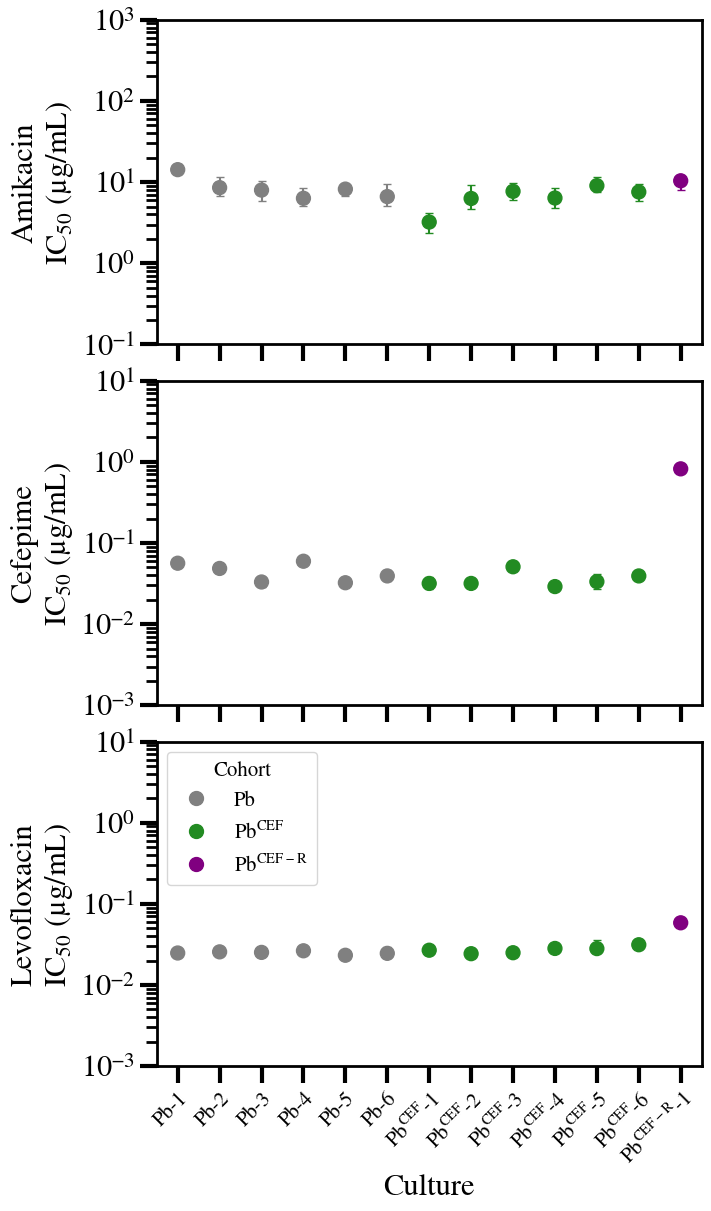

In [37]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Nimbus Roman"
plt.rcParams["mathtext.fontset"] = "custom"
plt.rcParams["mathtext.rm"] = "Nimbus Roman"


import re
manual_colors = {
    "ATEC": "grey",
    "ATEC-C": "forestgreen",
    "ATEC-C-r": "purple",
    "PL": "red"
}

def cohort_label(group):
    if group == "ATEC":
        return "Pb"
    elif group == "ATEC-C":
        return "Pb$^{\\mathrm{CEF}}$"
    elif group == "ATEC-C-r":
        return "Pb$^{\\mathrm{CEF-R}}$"
    else:
        return group  # Default to the original group name if no match
    

def custom_label(strain):
    # Match patterns for different strain types
    match = re.match(r'(ATEC|ATEC-C|ATEC-C-r)(\d+)', strain)
    if match:
        prefix, number = match.groups()  # Extract group and number
        if prefix == "ATEC":
            return f"Pb-{number}"
        elif prefix == "ATEC-C":
            return f"Pb$^{{\\mathrm{{CEF}}}}$-{number}"
        elif prefix == "ATEC-C-r":
            return f"Pb$^{{\\mathrm{{CEF-R}}}}$-{number}"
    # Default to the original strain label if no match
    return strain


# Dictionary of custom y-axis ranges for specific drugs
y_axis_ranges = {
    "Levofloxacin": (0.001, 10),
    "Amikacin": (.1, 1000),
    "Cefepime": (0.001, 10)
}

# Iterate over antibiotics to create subplots
fig, axes = plt.subplots(
    nrows=len(sorted(growth_features['Antibiotic'].unique())),
    figsize=(7, 12),
    constrained_layout=True
)

# Ensure axes is iterable even for a single plot
if len(sorted(growth_features['Antibiotic'].unique())) == 1:
    axes = [axes]

for ax, drug in zip(axes, sorted(growth_features['Antibiotic'].unique())):
    filtered_data = growth_features.query(f'Antibiotic == "{drug}" & Status == "PASS"')
    filtered_data['StrainGroup'] = filtered_data['Strain'].str.extract(r'(\D+)')

    # Add a sort key to maintain original strain order within the dataset
    filtered_data['SortOrder'] = filtered_data.index

    # Apply custom labels
    filtered_data['CustomLabel'] = filtered_data['Strain'].apply(custom_label)

    # Sort the labels numerically within groups, respecting original order
    filtered_data['NumericPart'] = filtered_data['Strain'].str.extract(r'(\d+)$').astype(int)
    filtered_data = filtered_data.sort_values(['StrainGroup', 'NumericPart', 'SortOrder'])

    # Extract values for plotting
    strains = filtered_data['CustomLabel']
    ic50 = filtered_data['IC50']
    ci_lower = filtered_data['IC50_ci_lower']
    ci_upper = filtered_data['IC50_ci_upper']
    insufficient_drug = filtered_data['insufficient_drug']
    strain_groups = filtered_data['StrainGroup']

    # Assign colors for each strain group
    unique_groups = strain_groups.unique()
    group_colors = {group: manual_colors.get(group, "black") for group in unique_groups}
    colors = strain_groups.map(group_colors)

    # Plot IC50 points
    scatter = ax.scatter(strains, ic50, color=colors, s=100, label=strain_groups)
    
    # Add error bars with matching colors
    for i, color in enumerate(colors):
        ax.errorbar(
            x=i,
            y=ic50.iloc[i],
            yerr=[[ic50.iloc[i] - ci_lower.iloc[i]], [ci_upper.iloc[i] - ic50.iloc[i]]],
            fmt='none',
            ecolor=color,
            capsize=3
        )

    # Add dagger annotations for insufficient drug
    for i, strain in enumerate(strains):
        if insufficient_drug.iloc[i]:
            ax.text(i, ic50.iloc[i] * 1.2, '‡', ha='center', va='bottom', fontsize=12, color='black')

    # Format the y-axis with log scale
    ax.set_yscale('log')
    
    # Apply custom y-axis range if the drug is in the dictionary
    if drug in y_axis_ranges:
        ax.set_ylim(y_axis_ranges[drug])

    ax.set_ylabel(f"{drug}\nIC$_{{50}}$ (μg/mL)", fontsize=22)
    ax.tick_params(axis='y', labelsize=22)  # Adjust 'labelsize' to your preferred size

    ax.set_xlim(-0.5, len(strains) - 0.5)  # Tighten edges by adding a small buffer
    
    for spine in ax.spines.values():
        spine.set_linewidth(2)  # Set thickness of the spine lines
    
    ax.tick_params(axis='both', which='major', length=12, width=3)  # Major ticks
    ax.tick_params(axis='both', which='minor', length=8, width=2)  # Minor ticks

    if drug == 'Levofloxacin':
        ax.set_xlabel('Culture', fontsize=22)
        ax.set_xticklabels(strains, fontsize=15, rotation=45, ha='right', rotation_mode = 'anchor') # Rotate labels 45 degrees
        ax.set_xticks(range(len(strains)))
         ## Create a legend with cohort labels
        handles = [plt.Line2D([0], [0], marker='o', color=color, markersize=10, linestyle='', 
                          label=cohort_label(group)) for group, color in group_colors.items()]
        ax.legend(handles=handles, title="Cohort", loc="upper left", fontsize=15, title_fontsize=15)

    else:
        ax.set_xticklabels("") # Rotate labels 45 degrees


    # Set tight x-axis limits

    # Rotate x-axis labels for readability
  # Rotate x-axis labels for readability


# Adjust legend
#  ## Create a legend with cohort labels
#     handles = [plt.Line2D([0], [0], marker='o', color=color, markersize=10, linestyle='', 
#                           label=cohort_label(group)) for group, color in group_colors.items()]
#     ax.legend(handles=handles, title="Cohort", loc="upper left", fontsize=15, title_fontsize=15)
final_chart_path = PROJECT_PATH / PROJECT_ID / 'figures'/'finals'/'0512_finals' / 'ATEC_IC50_individual.png'
plt.savefig(final_chart_path, dpi=600, bbox_inches='tight')
plt.show()
# Show plot
plt.show()


/tmp/ipykernel_15283/2743926259.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['StrainGroup'] = filtered_data['Strain'].str.extract(r'(\D+)')
/tmp/ipykernel_15283/2743926259.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['SortOrder'] = filtered_data.index
/tmp/ipykernel_15283/2743926259.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

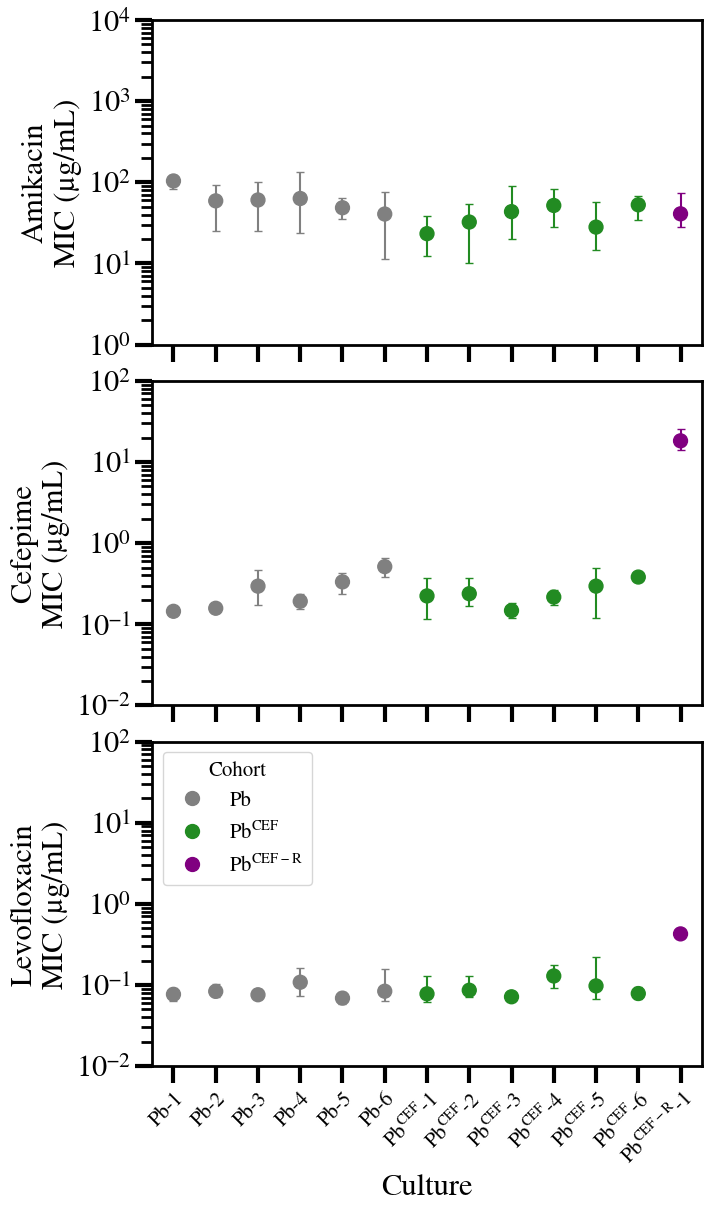

In [39]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Nimbus Roman"
plt.rcParams["mathtext.fontset"] = "custom"
plt.rcParams["mathtext.rm"] = "Nimbus Roman"


import re
manual_colors = {
    "ATEC": "grey",
    "ATEC-C": "forestgreen",
    "ATEC-C-r": "purple",
    "PL": "red"
}

def cohort_label(group):
    if group == "ATEC":
        return "Pb"
    elif group == "ATEC-C":
        return "Pb$^{\\mathrm{CEF}}$"
    elif group == "ATEC-C-r":
        return "Pb$^{\\mathrm{CEF-R}}$"
    else:
        return group  # Default to the original group name if no match
    

def custom_label(strain):
    # Match patterns for different strain types
    match = re.match(r'(ATEC|ATEC-C|ATEC-C-r)(\d+)', strain)
    if match:
        prefix, number = match.groups()  # Extract group and number
        if prefix == "ATEC":
            return f"Pb-{number}"
        elif prefix == "ATEC-C":
            return f"Pb$^{{\\mathrm{{CEF}}}}$-{number}"
        elif prefix == "ATEC-C-r":
            return f"Pb$^{{\\mathrm{{CEF-R}}}}$-{number}"
    # Default to the original strain label if no match
    return strain


# Dictionary of custom y-axis ranges for specific drugs
y_axis_ranges = {
    "Levofloxacin": (0.01, 100),
    "Amikacin": (1, 10000),
    "Cefepime": (0.01, 100)
}

# Iterate over antibiotics to create subplots
fig, axes = plt.subplots(
    nrows=len(sorted(growth_features['Antibiotic'].unique())),
    figsize=(7, 12),
    constrained_layout=True
)

# Ensure axes is iterable even for a single plot
if len(sorted(growth_features['Antibiotic'].unique())) == 1:
    axes = [axes]

for ax, drug in zip(axes, sorted(growth_features['Antibiotic'].unique())):
    filtered_data = growth_features.query(f'Antibiotic == "{drug}" & Status == "PASS"')
    filtered_data['StrainGroup'] = filtered_data['Strain'].str.extract(r'(\D+)')

    # Add a sort key to maintain original strain order within the dataset
    filtered_data['SortOrder'] = filtered_data.index

    # Apply custom labels
    filtered_data['CustomLabel'] = filtered_data['Strain'].apply(custom_label)

    # Sort the labels numerically within groups, respecting original order
    filtered_data['NumericPart'] = filtered_data['Strain'].str.extract(r'(\d+)$').astype(int)
    filtered_data = filtered_data.sort_values(['StrainGroup', 'NumericPart', 'SortOrder'])

    # Extract values for plotting
    strains = filtered_data['CustomLabel']
    mic50 = filtered_data['MIC']
    ci_lower = filtered_data['MIC_ci_lower']
    ci_upper = filtered_data['MIC_ci_upper']
    insufficient_drug = filtered_data['insufficient_drug']
    strain_groups = filtered_data['StrainGroup']

    # Assign colors for each strain group
    unique_groups = strain_groups.unique()
    group_colors = {group: manual_colors.get(group, "black") for group in unique_groups}
    colors = strain_groups.map(group_colors)

    # Plot IC50 points
    scatter = ax.scatter(strains, mic50, color=colors, s=100, label=strain_groups)
    
    # Add error bars with matching colors
    for i, color in enumerate(colors):
        ax.errorbar(
            x=i,
            y=mic50.iloc[i],
            yerr=[[mic50.iloc[i] - ci_lower.iloc[i]], [ci_upper.iloc[i] - mic50.iloc[i]]],
            fmt='none',
            ecolor=color,
            capsize=3
        )

    # Add dagger annotations for insufficient drug
    for i, strain in enumerate(strains):
        if insufficient_drug.iloc[i]:
            ax.text(i, mic50.iloc[i] * 1.2, '‡', ha='center', va='bottom', fontsize=12, color='black')

    # Format the y-axis with log scale
    ax.set_yscale('log')
    
    # Apply custom y-axis range if the drug is in the dictionary
    if drug in y_axis_ranges:
        ax.set_ylim(y_axis_ranges[drug])

    ax.set_ylabel(f"{drug}\nMIC (μg/mL)", fontsize=22)
    ax.tick_params(axis='y', labelsize=22)  # Adjust 'labelsize' to your preferred size

    ax.set_xlim(-0.5, len(strains) - 0.5)  # Tighten edges by adding a small buffer
    
    for spine in ax.spines.values():
        spine.set_linewidth(2)  # Set thickness of the spine lines
    
    ax.tick_params(axis='both', which='major', length=12, width=3)  # Major ticks
    ax.tick_params(axis='both', which='minor', length=8, width=2)  # Minor ticks

    if drug == 'Levofloxacin':
        ax.set_xlabel('Culture', fontsize=22)
        ax.set_xticklabels(strains, fontsize=15, rotation=45, ha='right', rotation_mode = 'anchor') # Rotate labels 45 degrees
        ax.set_xticks(range(len(strains)))
         ## Create a legend with cohort labels
        handles = [plt.Line2D([0], [0], marker='o', color=color, markersize=10, linestyle='', 
                          label=cohort_label(group)) for group, color in group_colors.items()]
        ax.legend(handles=handles, title="Cohort", loc="upper left", fontsize=15, title_fontsize=15)

    else:
        ax.set_xticklabels("") # Rotate labels 45 degrees


    # Set tight x-axis limits

    # Rotate x-axis labels for readability
  # Rotate x-axis labels for readability


# Adjust legend
#  ## Create a legend with cohort labels
#     handles = [plt.Line2D([0], [0], marker='o', color=color, markersize=10, linestyle='', 
#                           label=cohort_label(group)) for group, color in group_colors.items()]
#     ax.legend(handles=handles, title="Cohort", loc="upper left", fontsize=15, title_fontsize=15)
final_chart_path = PROJECT_PATH / PROJECT_ID / 'figures'/'finals' /'0512_finals'/ 'ATEC_MIC_individual.png'
plt.savefig(final_chart_path, dpi=600, bbox_inches='tight')
plt.show()
# Show plot
plt.show()
